In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nepsa/NepSA.csv
/kaggle/input/fasttext/__results__.html
/kaggle/input/fasttext/__notebook__.ipynb
/kaggle/input/fasttext/__output__.json
/kaggle/input/fasttext/custom.css
/kaggle/input/fasttext/finetune/finetune.syn1neg.npy
/kaggle/input/fasttext/finetune/finetune.wv.vectors_vocab.npy
/kaggle/input/fasttext/finetune/finetune.wv.vectors_ngrams.npy
/kaggle/input/fasttext/finetune/finetune
/kaggle/input/fasttext/scratch/scratch.wv.vectors_ngrams.npy
/kaggle/input/fasttext/scratch/scratch
/kaggle/input/nephased-datasets/__results__.html
/kaggle/input/nephased-datasets/__notebook__.ipynb
/kaggle/input/nephased-datasets/__output__.json
/kaggle/input/nephased-datasets/custom.css
/kaggle/input/nephased-datasets/torch_datasets/train.pt
/kaggle/input/nephased-datasets/torch_datasets/val.pt
/kaggle/input/nephased-datasets/torch_datasets/test.pt
/kaggle/input/nephased-datasets/torch_datasets/datasets.py
/kaggle/input/nephased-datasets/torch_datasets/__pycache__/datasets.cpython-311.p

# ResLSTM with Fasttext
## Loading fasttext and dataset

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from gensim.models import FastText
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.metrics import precision_score,confusion_matrix, precision_recall_curve, classification_report, average_precision_score, ConfusionMatrixDisplay, matthews_corrcoef
from pathlib import Path
import shutil, random, copy, multiprocessing

# Custom Dataset function
Path("./custom_dataset").mkdir()
shutil.copy(Path("/kaggle/input/nephased-datasets/torch_datasets/datasets.py"), Path("./custom_dataset/"))
from custom_dataset.datasets import SequenceDataset

# Residual LSTM implementation
shutil.copy(Path("/kaggle/input/pretrained-fasttext/lstm.py"), Path("./"))
from lstm import ResLSTM

# Embedding model path
fasttext_path = "/kaggle/input/fasttext/finetune/finetune"

## Setting Seed for reproducibility

In [3]:
def set_seed(seed=42):
    os.environ["PL_GLOBAL_SEED"] = str(seed)
    random.seed(seed)                      # Python random
    np.random.seed(seed)                   # NumPy
    torch.manual_seed(seed)                # PyTorch CPU
    torch.cuda.manual_seed(seed)           # PyTorch CUDA
    torch.cuda.manual_seed_all(seed)       # All GPUs
    torch.backends.cudnn.deterministic = True  # Force deterministic ops
    torch.backends.cudnn.benchmark = False     # Disable auto benchmark

set_seed(42)

In [4]:
# Loading the embedder
fasttext = FastText.load(fasttext_path)

print(fasttext.wv["ठोक"])

[ 4.55772549e-01 -3.80640984e-01  7.07274020e-01 -2.07509875e-01
  1.16996415e-01  1.97128505e-01  5.39681800e-02  7.82762825e-01
 -1.85917258e-01  3.95387501e-01  7.24388892e-03 -2.25900244e-02
 -1.90978020e-01  1.50602618e-02  1.08879387e-01 -4.63932186e-01
  2.13423356e-01  3.14832866e-01  2.57830918e-01 -2.62599528e-01
 -1.50396079e-01  8.54797363e-02 -1.09494343e-01 -6.50232881e-02
 -1.97346702e-01  1.01050474e-01  4.71219420e-02  4.67746496e-01
  4.91460226e-02  7.62483001e-01 -5.11163056e-01  2.06212848e-01
  2.71505360e-02 -3.97237949e-02  4.24112320e-01 -2.48253539e-01
 -7.28109032e-02 -4.89572175e-02  5.83732665e-01  1.22758098e-01
  2.51013577e-01 -6.02305412e-01  4.56145667e-02  3.08198959e-01
 -2.28192553e-01 -8.33753198e-02  2.59751439e-01 -3.51396978e-01
 -5.58147490e-01  2.77043462e-01 -4.60368067e-01 -1.93240210e-01
  1.88530788e-01 -1.04565963e-01 -1.56487569e-01  1.96220025e-01
  2.17818394e-01 -2.07896993e-01 -3.21577519e-01 -2.62960582e-03
 -3.76222551e-01  3.98864

In [5]:
# Getting the Dataset
train = torch.load("/kaggle/input/nephased-datasets/torch_datasets/train.pt")
test = torch.load("/kaggle/input/nephased-datasets/torch_datasets/test.pt")
val = torch.load("/kaggle/input/nephased-datasets/torch_datasets/val.pt")

print(len(train["sentences"]))
print(test["sentences"][0])
print(len(test["labels"]))

3765
['गोलि', 'हान्यो', 'तिर्थ', 'लाइ', 'प्रहरी', 'चोर', 'होश', 'प्रबक्ता', '।']
471


For fasttext model we cannot enter padsequence zero vector as sub word generation will create non-zero vector which contradicts our implementations on masking

## Transforming text to vectors with our custom torch dataset class

In [6]:
# Using custom dataset to get vectors for our tokens
finetuned_train = SequenceDataset(train["sentences"], binary=True, model=fasttext, labels=train["labels"])
finetuned_test = SequenceDataset(test["sentences"], binary=True, model=fasttext, labels=test["labels"])
finetuned_val = SequenceDataset(val["sentences"], binary=True, model=fasttext, labels=val["labels"])

we map labels to general, light_profanity, high_profanity and violence

In [7]:
# label map int to string
label_map = {
    0: 'GENERAL',
    1: 'LIGHT_PROFANITY',
    2: 'HIGH_PROFANITY',
    3: 'VIOLENCE'
}

num_classes= 4

In [8]:
class LabelModifiedDataset(Dataset):
    def __init__(self, original_dataset):
        self.original_dataset = original_dataset
        self.label_mapping = {
            0: 0,
            1: 0,
            2: 1,
            3: 2,
            4: 3,
            5: 3
        }
    
    def __len__(self):
        return len(self.original_dataset)
    
    def __getitem__(self, idx):
        item = self.original_dataset[idx]
        
        features, mask, label = item
        
        # Apply the specific mapping rules
        original_label = label.item()
        new_label = self.label_mapping.get(original_label, original_label)      
        
        return (features, mask, torch.tensor(new_label, dtype=label.dtype))

finetuned_train = LabelModifiedDataset(finetuned_train)
finetuned_test = LabelModifiedDataset(finetuned_test)
finetuned_val = LabelModifiedDataset(finetuned_val)

In [9]:
print(finetuned_val[0])
print(finetuned_test[0][0])

(tensor([[-0.4693, -0.2960,  0.1048,  ...,  0.4016, -0.0490,  0.8631],
        [-0.1391, -1.1462,  0.4359,  ..., -0.1044,  0.0812, -0.1467],
        [-0.0035, -0.4982, -0.0081,  ..., -0.1271,  0.0196,  0.2892],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]]), tensor([ True,  True,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, Fal

/kaggle/working/custom_dataset/datasets.py:47: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  torch.tensor(vectors, dtype=torch.float32),


In [10]:
print(finetuned_train[0][0].shape)

torch.Size([100, 300])


In [11]:
print(len(finetuned_train))
print(len(finetuned_test))

3765
471


In [12]:
num_workers = multiprocessing.cpu_count()
train_loader = DataLoader(finetuned_train, batch_size=16, shuffle=True, pin_memory=True, num_workers = 0)
test_loader = DataLoader(finetuned_test, batch_size=16, shuffle=True, pin_memory=True, num_workers = 0)
val_loader = DataLoader(finetuned_val, batch_size=16, shuffle=True, pin_memory=True, num_workers = 0)

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

sequence_length, embeddings_size= finetuned_train[0][0].shape
print(sequence_length)
print(embeddings_size)

Using device: cuda
100
300


## Get trainable paramters

In [14]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


## Training Function

In [15]:
def model_train(model, criterion, optimizer, train_loader, val_loader,scheduler=None, 
                save_name=None, epochs=20, patience=3, early_stopping=False, dnn=False, model2=False):
    '''
        Deep Network training function which excpects model, criterion, scheuler, train data loader and val data loader
        Early stopping can be done for regularization by setting early_stopping (default: False)
        and providing early stopping patience (default: 3)
        save_name if provided saves the plot in working directory with "save_name"_loss.png 
        --
        returns : model with least val loss, list of train and val loss per epoch
        
    '''

    if not isinstance(epochs, int) or epochs <= 0:
        raise ValueError("epochs must be a positive integer.")
    
    if not isinstance(patience, int) or patience <= 0:
        raise ValueError("patience must be a positive integer.")

    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []
    train_precisions, val_precisions = [], []
    
    best_val_loss = float('inf')
    best_epoch = 0
    best_model_weights = None
    patience_counter = 0  # for early stopping

    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0
        correct = 0
        total = 0
        train_preds_list = []
        train_targets_list = []

        for batch in train_loader:
            if model2:
                X_batch, X_batch_mean, mask, y_batch = batch
                X_batch = X_batch.to(device)
                X_batch_mean = X_batch_mean.to(device)
                mask = mask.to(device)
                y_batch = y_batch.to(device)
                optimizer.zero_grad()
                outputs, _ = model(X_batch, X_batch_mean, mask)
            else:
                X_batch, mask, y_batch = batch
                X_batch = X_batch.to(device)
                mask = mask.to(device)
                y_batch = y_batch.to(device)
                optimizer.zero_grad()
                if dnn:
                    outputs = model(X_batch)
                else:
                    outputs, _ = model(X_batch, mask)
                
            loss = criterion(outputs, y_batch)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            if scheduler:
                scheduler.step()

            train_loss += loss.item()
            preds = outputs.argmax(dim=1)
            correct += (preds == y_batch).sum().item()
            total += y_batch.size(0)
            train_preds_list.extend(preds.cpu().numpy())
            train_targets_list.extend(y_batch.cpu().numpy())

        train_losses.append(train_loss / len(train_loader))
        train_accuracies.append(correct / total)
        train_precision = precision_score(train_targets_list, train_preds_list, average='macro', zero_division=0)
        train_precisions.append(train_precision)

        # Validation phase
        model.eval()
        val_loss = 0
        correct = 0
        total = 0
        val_preds_list = []
        val_targets_list = []

        with torch.no_grad():
            for batch in val_loader:
                if model2:
                    X_batch, X_batch_mean, mask, y_batch = batch
                    X_batch = X_batch.to(device)
                    X_batch_mean = X_batch_mean.to(device)
                    mask = mask.to(device)
                    y_batch = y_batch.to(device)
                    outputs, _ = model(X_batch, X_batch_mean, mask)
                else:
                    X_batch, mask, y_batch = batch
                    X_batch = X_batch.to(device)
                    mask = mask.to(device)
                    y_batch = y_batch.to(device)
                    if dnn:
                        outputs = model(X_batch)
                    else:
                        outputs, _ = model(X_batch, mask)
                    
                loss = criterion(outputs, y_batch)
                val_loss += loss.item()

                preds = outputs.argmax(dim=1)
                correct += (preds == y_batch).sum().item()
                total += y_batch.size(0)
                val_preds_list.extend(preds.cpu().numpy())
                val_targets_list.extend(y_batch.cpu().numpy())
                
        current_val_loss = val_loss / len(val_loader)
        val_losses.append(current_val_loss)
        val_accuracies.append(correct / total)
        val_precision = precision_score(val_targets_list, val_preds_list, average='macro', zero_division=0)
        val_precisions.append(val_precision)

        # Early stopping logic
        if current_val_loss < best_val_loss:
            best_val_loss = current_val_loss
            best_epoch = epoch + 1 
            best_model_weights = copy.deepcopy(model.state_dict())
            patience_counter = 0
        else:
            if early_stopping:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f"Early stopping at epoch {epoch+1} (no improvement in {patience} epochs)")
                    break

        print(f"Epoch {epoch+1}/{epochs} | "
              f"Train Loss: {train_losses[-1]:.4f} | Val Loss: {val_losses[-1]:.4f} | "
              f"Train Acc: {train_accuracies[-1]*100:.2f}% | Val Acc: {val_accuracies[-1]*100:.2f}%")

    # Plotting with vertical dotted line for best epoch
    plt.figure(figsize=(18, 6))

    if save_name: # Use save_name as the main title if provided
        plt.suptitle(f"Training Metrics for: {save_name}", fontsize=16)
    else: # Fallback title if save_name is not provided
        plt.suptitle("Training Metrics", fontsize=16)
    
    # Loss plot
    plt.subplot(1, 3, 1)
    plt.plot(range(1, len(train_losses)+1), train_losses, label='Train Loss')
    plt.plot(range(1, len(val_losses)+1), val_losses, label='Val Loss')
    plt.axvline(x=best_epoch, color='red', linestyle=':', 
                label=f'Best Epoch: {best_epoch}\nVal Loss: {best_val_loss:.4f}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Curve')
    plt.legend()
    plt.grid(True)

    # Accuracy plot
    plt.subplot(1, 3, 2)
    plt.plot(range(1, len(train_accuracies)+1), train_accuracies, label='Train Acc')
    plt.plot(range(1, len(val_accuracies)+1), val_accuracies, label='Val Acc')
    plt.axvline(x=best_epoch, color='red', linestyle=':', 
                label=f'Best Epoch: {best_epoch}\nVal Acc: {val_accuracies[best_epoch-1]*100:.2f}%')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Curve')
    plt.legend()
    plt.grid(True)

    # Precision plot 
    plt.subplot(1, 3, 3) 
    plt.plot(range(1, len(train_precisions)+1), train_precisions, label='Train Precision')
    plt.plot(range(1, len(val_precisions)+1), val_precisions, label='Val Precision')
    best_val_prec_at_best_loss_epoch = val_precisions[best_epoch-1] if best_epoch > 0 else 0
    plt.axvline(x=best_epoch, color='red', linestyle=':',
                label=f'Best Epoch: {best_epoch}\nVal Prec: {best_val_prec_at_best_loss_epoch*100:.2f}%')
    plt.xlabel('Epoch')
    plt.ylabel('Precision')
    plt.title('Macro Precision Curve')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    if save_name:
        print(f"Training curves(Loss, accuracy, macro precision) will be saved as {save_name}_loss.png")
        plt.savefig(f"/kaggle/working/{save_name}_loss.png", bbox_inches='tight', dpi=300)
    plt.show()

    # Load best model weights
    model.load_state_dict(best_model_weights)
    
    return model, train_losses, val_losses

## Evaluating Function

In [16]:
def evaluate_model(model, test_loader, label_map=None, save_name = None, dnn=False, model2=False):
    '''
        Use save_name to version control
        when save_name is given returns classification report dict
    '''
    model.eval()  # Set model to evaluation mode
    all_labels = []
    all_preds = []
    all_probs = []

    with torch.no_grad():
        for batch in test_loader:
            if model2:
                X_batch, X_batch_mean, mask, y_batch = batch
                X_batch = X_batch.to(device)
                X_batch_mean = X_batch_mean.to(device)
                mask = mask.to(device)
                y_batch = y_batch.to(device)
                outputs, _ = model(X_batch, X_batch_mean, mask)
            else:
                X_batch, mask, y_batch = batch
                X_batch = X_batch.to(device)
                mask = mask.to(device)
                y_batch = y_batch.to(device)
                if dnn:
                    outputs = model(X_batch)
                else:
                    outputs, _ = model(X_batch, mask)
            probs = torch.softmax(outputs, dim=1)  # Shape: (batch_size, num_classes)
            preds = torch.argmax(probs, dim=1)

            all_labels.extend(y_batch.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    # Convert to numpy arrays
    all_labels = np.array(all_labels)
    all_preds = np.array(all_preds)
    all_probs = np.array(all_probs)
    num_classes = all_probs.shape[1]

    # Compute the Matthews correlation coefficient (MCC)
    mcc = matthews_corrcoef(all_labels, all_preds)
    print(f"Matthews correlation coefficient: {mcc}\n-------------------------------------\n")
    
    # Classification report
    print("Classification Report:")
    print(classification_report(all_labels, all_preds, labels=list(label_map.keys()), target_names=list(label_map.values())))

    # PR Curve for each class
    plt.figure(figsize=(10, 6))
    for i in range(num_classes):
        precision, recall, _ = precision_recall_curve(all_labels == i, all_probs[:, i])
        avg_precision = average_precision_score(all_labels == i, all_probs[:, i])
        if not label_map:
            plt.plot(recall, precision, label=f'Class {i} (AP = {avg_precision:.2f})')
        else:
            plt.plot(recall, precision, label=f'{label_map[i]} (AP = {avg_precision:.2f})')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve (Per-Class)')
    plt.legend(loc='upper right')
    plt.grid()
    if save_name:
        print(f"PR curve will be saved as {save_name}_PR.png")
        plt.savefig(f"/kaggle/working/{save_name}_PR.png", bbox_inches='tight', dpi=300)
    plt.show()

    # Confusion Matrix 
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(12, 8))
    
    if not label_map:
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(all_labels))
    else:
        labels = [label_map[i] for i in sorted(label_map.keys())]
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    
    disp.plot(cmap='Blues', values_format='d', ax=plt.gca())
    plt.title('Confusion Matrix', pad=20, fontsize=14)
    
    # Rotate x-axis labels and adjust layout
    plt.xticks(rotation=45, ha='right', rotation_mode='anchor')
    plt.yticks(rotation=0)
    plt.tight_layout() 
    plt.grid(False)
    plt.gca().set_facecolor('#f8f8f8')  
    if save_name:
        print(f"Confusion Matrix will be saved as {save_name}_cm.png")
        plt.savefig(f"/kaggle/working/{save_name}_cm.png", bbox_inches='tight', dpi=300)
    
    plt.show()

    if save_name:
        classification_dict = classification_report(all_labels, all_preds, output_dict=True)
        classification_dict["mcc"] = mcc
        return classification_dict

## A simple DNN classifier

### Dataset without sequence padding

In [17]:
class DNNModifiedDataset(Dataset):
    def __init__(self, original_dataset):
        self.original_dataset = original_dataset
    
    def __len__(self):
        return len(self.original_dataset)
    
    def __getitem__(self, idx):
        item = self.original_dataset[idx]
        
        features, mask, label = item
        
        if mask.dtype != torch.bool:
            mask = mask.bool() 

        filtered_features = features[mask]
        mean_features = torch.mean(filtered_features, dim=0)
            
        return (mean_features, mask, label)

dnn_train = DNNModifiedDataset(finetuned_train)
dnn_test = DNNModifiedDataset(finetuned_test)
dnn_val = DNNModifiedDataset(finetuned_val)

print(dnn_val[0])
print(dnn_test[0][0])
print(dnn_train[0][0].shape)

(tensor([-0.2040, -0.6468,  0.1775, -0.6752, -0.0276,  0.1302, -0.0982,  0.2182,
         0.0136,  0.1877,  0.0426, -0.6137, -0.2776,  0.1118,  0.3178, -0.1425,
        -0.0661,  0.0390, -0.1968,  0.1642,  0.1866, -0.2364, -0.1634, -0.6539,
        -0.2633,  0.3028,  0.2983,  0.5221,  0.1339,  0.5018, -0.3041,  0.3166,
         0.4054, -0.0437,  0.4260, -0.3281, -0.2381, -0.3119,  0.4744,  0.0748,
         0.2848, -0.2963,  0.0263,  0.1234, -0.1134,  0.1148,  0.0738, -0.4540,
        -0.2942, -0.0792, -0.1504, -0.2552,  0.0905,  0.1245, -0.1891,  0.2769,
         0.1850,  0.0687, -0.2092, -0.1710, -0.2193,  0.0599, -0.0320,  0.3510,
        -0.1209, -0.4022, -0.2526,  0.1784, -0.5616, -0.0686, -0.0336, -0.2525,
        -0.4044, -0.0304, -0.6410,  0.0162, -0.7274,  0.2808, -0.1257, -0.6931,
         0.1487,  0.0531,  0.0694, -0.0579, -0.3147, -0.0940, -0.0249, -0.0054,
         0.0242, -0.1962, -0.6815,  0.1827, -0.3863,  0.0155, -0.2026, -0.0249,
        -0.2822, -0.0761, -0.4066, -0.2

In [18]:
# Simple feedforward neural network
class DNN_Classifier(nn.Module):
    def __init__(self, input_dim, output_dim,input_neurons=64, hidden_neurons=32, input_dropout=0.3, hidden_dropout=0.3):
        super(DNN_Classifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, input_neurons)
        self.bn1 = nn.BatchNorm1d(input_neurons)
        self.dropout1 = nn.Dropout(input_dropout)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(input_neurons, hidden_neurons)
        self.bn2 = nn.BatchNorm1d(hidden_neurons)
        self.dropout2 = nn.Dropout(hidden_dropout)
        self.fc3 = nn.Linear(hidden_neurons, output_dim) 
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.dropout2(x)
        x = self.fc3(x)
        return x

dnn_params = {
    "input_dim" : embeddings_size,
    "input_layer_neurons" : 64,
    "hidden_layer_neurons" : 32,
    "input_dropout": 0.3,
    "hidden_dropout": 0.3,
    "lr" : 1e-4,
    "epochs":100,
    "train_batch_size" : 8,
    "test_batch_size" : 8,
    "val_batch_size" : 8,
    "num_classes": num_classes
}

dnn_init_params = {
    "input_dim": dnn_params["input_dim"],
    "input_neurons": dnn_params["input_layer_neurons"],
    "hidden_neurons": dnn_params["hidden_layer_neurons"],
    "input_dropout": dnn_params["input_dropout"],
    "hidden_dropout": dnn_params["hidden_dropout"], 
    "output_dim": dnn_params["num_classes"]
}

# Initiate the model
dnn = DNN_Classifier(**dnn_init_params).to(device)

print(dnn)
print("\n----------------------------------------------------\n")
print(count_parameters(dnn))

DNN_Classifier(
  (fc1): Linear(in_features=300, out_features=64, bias=True)
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout(p=0.3, inplace=False)
  (relu): ReLU()
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout2): Dropout(p=0.3, inplace=False)
  (fc3): Linear(in_features=32, out_features=4, bias=True)
)

----------------------------------------------------

21668


Epoch 1/100 | Train Loss: 1.2811 | Val Loss: 1.0602 | Train Acc: 41.54% | Val Acc: 63.06%
Epoch 2/100 | Train Loss: 1.0046 | Val Loss: 0.8721 | Train Acc: 62.05% | Val Acc: 70.70%
Epoch 3/100 | Train Loss: 0.8967 | Val Loss: 0.7876 | Train Acc: 68.18% | Val Acc: 71.76%
Epoch 4/100 | Train Loss: 0.8369 | Val Loss: 0.7308 | Train Acc: 68.87% | Val Acc: 74.10%
Epoch 5/100 | Train Loss: 0.7627 | Val Loss: 0.7124 | Train Acc: 72.86% | Val Acc: 73.89%
Epoch 6/100 | Train Loss: 0.7322 | Val Loss: 0.6770 | Train Acc: 73.31% | Val Acc: 74.31%
Epoch 7/100 | Train Loss: 0.7287 | Val Loss: 0.6545 | Train Acc: 73.44% | Val Acc: 76.43%
Epoch 8/100 | Train Loss: 0.6941 | Val Loss: 0.6484 | Train Acc: 74.42% | Val Acc: 76.01%
Epoch 9/100 | Train Loss: 0.6927 | Val Loss: 0.6020 | Train Acc: 75.27% | Val Acc: 78.34%
Epoch 10/100 | Train Loss: 0.6627 | Val Loss: 0.5896 | Train Acc: 76.15% | Val Acc: 79.62%
Epoch 11/100 | Train Loss: 0.6639 | Val Loss: 0.5790 | Train Acc: 76.55% | Val Acc: 80.25%
Epoch 12

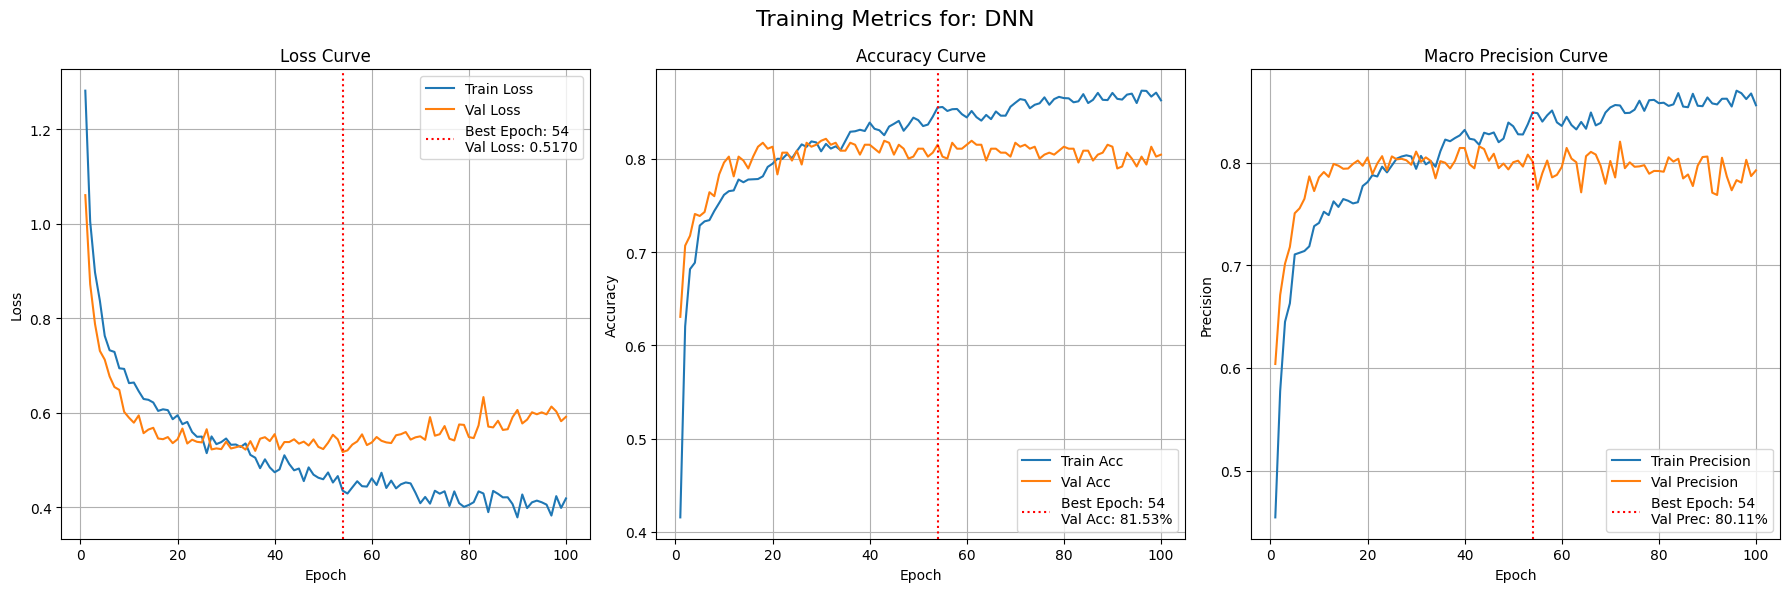

In [19]:
dnn_train_loader = DataLoader(dnn_train, batch_size=8, shuffle=True, pin_memory=True, num_workers = 0)
dnn_test_loader = DataLoader(dnn_test, batch_size=8, shuffle=True, pin_memory=True, num_workers = 0)
dnn_val_loader = DataLoader(dnn_val, batch_size=8, shuffle=True, pin_memory=True, num_workers = 0)

# loss function and Adam Optimizer
dnn_criterion = nn.CrossEntropyLoss()  # For multi-class classification
dnn_optimizer = optim.Adam(dnn.parameters(), lr=dnn_params["lr"] )  # Adam optimizer

dnn, dnn_train_losses, dnn_val_losses = model_train(dnn, dnn_criterion, dnn_optimizer, dnn_train_loader, dnn_val_loader, save_name="DNN", epochs=dnn_params["epochs"], dnn=True)


Matthews correlation coefficient: 0.7374404185275475
-------------------------------------

Classification Report:
                 precision    recall  f1-score   support

        GENERAL       0.83      0.91      0.87       190
LIGHT_PROFANITY       0.77      0.68      0.72        94
 HIGH_PROFANITY       0.76      0.70      0.73        60
       VIOLENCE       0.83      0.83      0.83       127

       accuracy                           0.82       471
      macro avg       0.80      0.78      0.79       471
   weighted avg       0.81      0.82      0.81       471



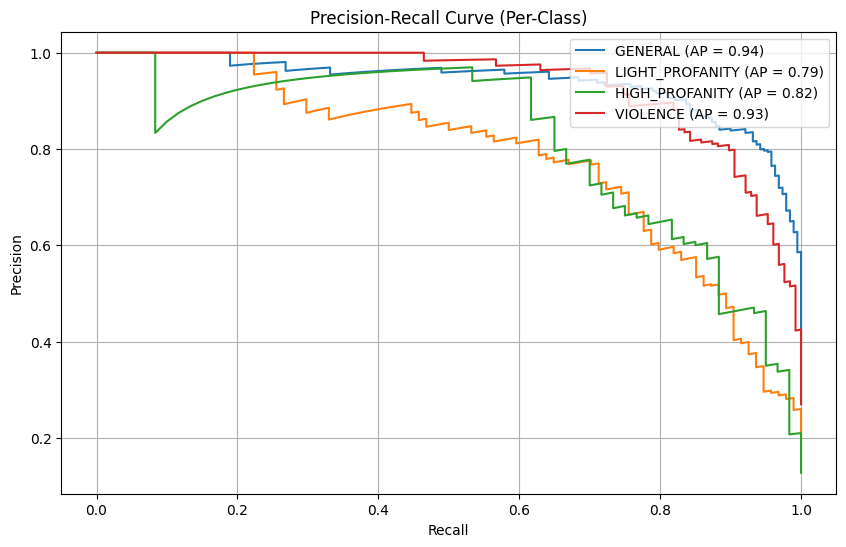

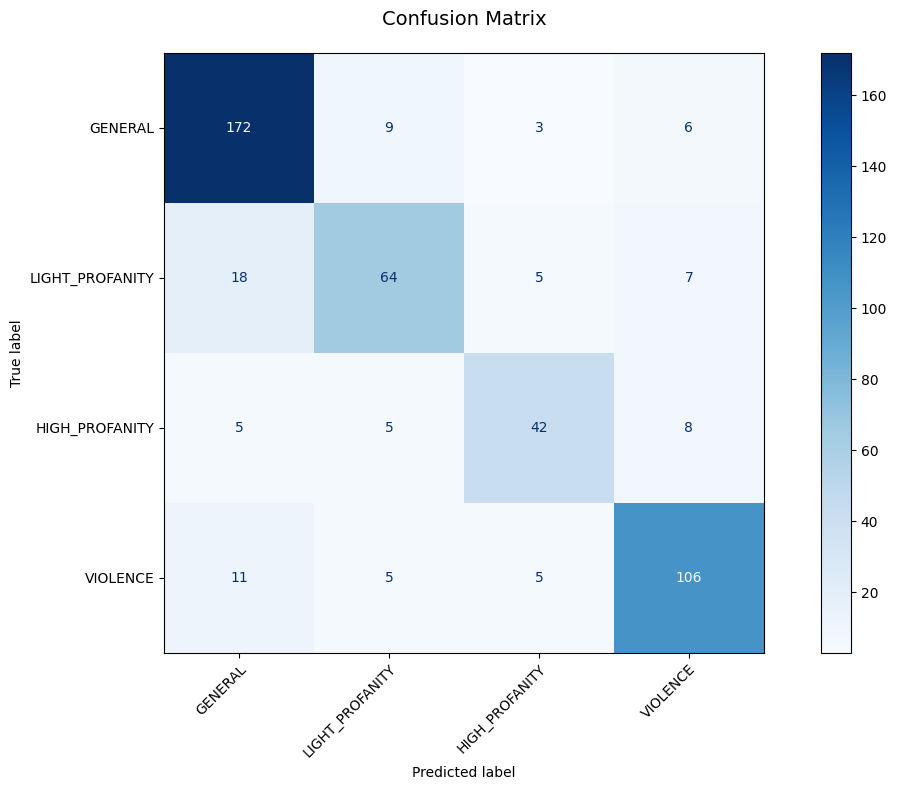

In [20]:
evaluate_model(dnn, dnn_val_loader, label_map, dnn=True)

Matthews correlation coefficient: 0.7270890125453764
-------------------------------------

Classification Report:
                 precision    recall  f1-score   support

        GENERAL       0.81      0.87      0.84       189
LIGHT_PROFANITY       0.66      0.67      0.67        94
 HIGH_PROFANITY       0.82      0.82      0.82        60
       VIOLENCE       0.91      0.80      0.85       128

       accuracy                           0.81       471
      macro avg       0.80      0.79      0.79       471
   weighted avg       0.81      0.81      0.81       471

PR curve will be saved as DNN_PR.png


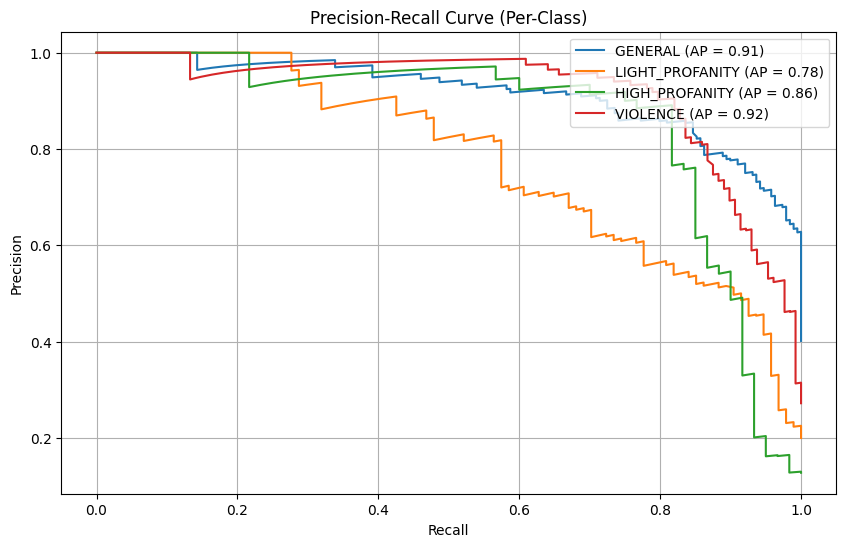

Confusion Matrix will be saved as DNN_cm.png


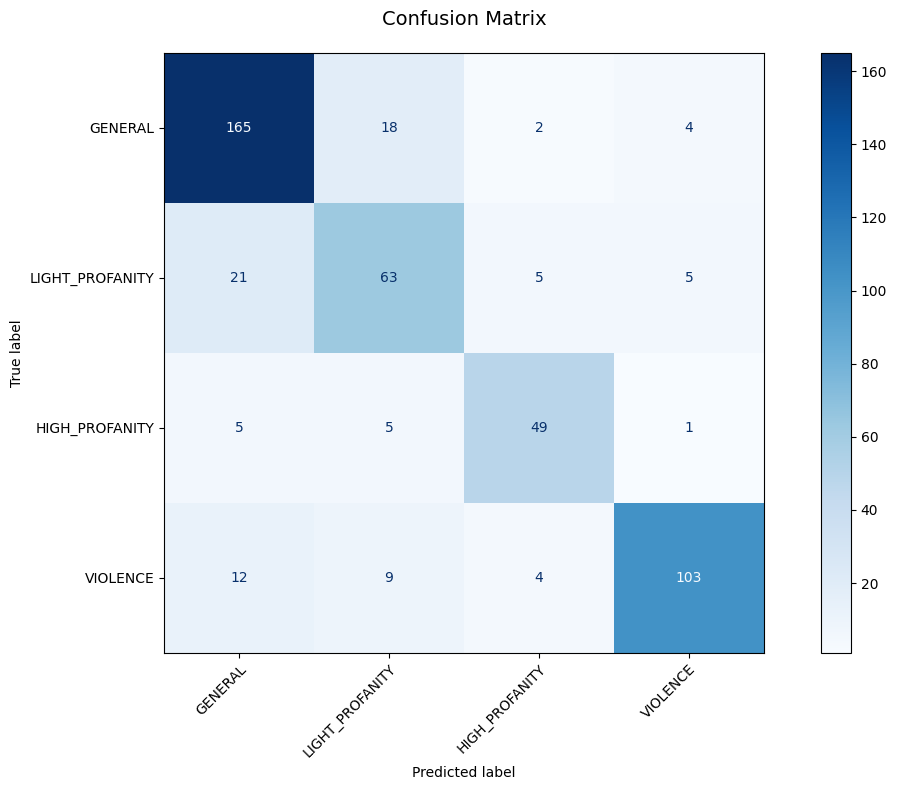

{'0': {'precision': 0.812807881773399,
  'recall': 0.873015873015873,
  'f1-score': 0.8418367346938775,
  'support': 189},
 '1': {'precision': 0.6631578947368421,
  'recall': 0.6702127659574468,
  'f1-score': 0.6666666666666666,
  'support': 94},
 '2': {'precision': 0.8166666666666667,
  'recall': 0.8166666666666667,
  'f1-score': 0.8166666666666667,
  'support': 60},
 '3': {'precision': 0.911504424778761,
  'recall': 0.8046875,
  'f1-score': 0.8547717842323652,
  'support': 128},
 'accuracy': 0.8067940552016986,
 'macro avg': {'precision': 0.8010342169889172,
  'recall': 0.7911457014099966,
  'f1-score': 0.7949854630648939,
  'support': 471},
 'weighted avg': {'precision': 0.8102549854185074,
  'recall': 0.8067940552016986,
  'f1-score': 0.8071859828143361,
  'support': 471},
 'mcc': 0.7270890125453764}

In [21]:
dnn_report = evaluate_model(dnn, dnn_test_loader, label_map, save_name="DNN", dnn=True)
dnn_report

## Warmup Function

In [22]:
def get_linear_warmup_scheduler(optimizer, warmup_steps, total_steps):
    def lr_lambda(current_step):
        # Linear lr increase
        if current_step < warmup_steps:
            return float(current_step) / float(max(1, warmup_steps))
        # Linearly decay lr
        return max(
            0.0, float(total_steps - current_step) / float(max(1, total_steps - warmup_steps))
        )
    return torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

## BiLSTM with attention

In [23]:
# Supports both residual and plain lstm
class BiLSTMAttn(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes, num_layers=1, dropout=0.5, bidirectional=True, lstm_dropout=0, residual=False):
        super().__init__()
        self.lstm = ResLSTM(input_dim, hidden_dim,num_layers=num_layers, batch_first=True, bidirectional=bidirectional) if residual else nn.LSTM(input_dim, hidden_dim,num_layers=num_layers, dropout=lstm_dropout, batch_first=True, bidirectional=bidirectional) 
        self.direction = 2 if bidirectional else 1
        self.ln = nn.LayerNorm(hidden_dim * self.direction)
        self.dropout = nn.Dropout(dropout)
        self.attn = nn.Linear(hidden_dim * self.direction, 1) # since BiLSTM
        self.fc = nn.Linear(hidden_dim * self.direction, num_classes)

    def forward(self, x, mask):
        lstm_out, _ = self.lstm(x)  # (Batch, SequenceLength, 2 * Hidden Dim)
        lstm_out = self.ln(lstm_out)  # Normalize
        lstm_out = self.dropout(lstm_out)  # Dropout

        # Attention scores
        scores = self.attn(lstm_out).squeeze(-1)  # (B, L)

        # Mask padding positions
        scores = scores.masked_fill(~mask, float('-inf'))  # invalid positions → -inf

        attn_weights = torch.softmax(scores, dim=1)  # (B, L)
        attn_weights = attn_weights.unsqueeze(-1)   # (B, L, 1)

        # Weighted sum
        context = torch.sum(attn_weights * lstm_out, dim=1)  # (B, 2H)
        context = self.ln(context) # normalize before FC
        logits = self.fc(context)  # (B, num_classes)

        return logits, attn_weights
        
BiLSTM_params = {
    "input_dim" : embeddings_size,
    "hidden_dim" : 148,
    "num_classes" : num_classes,
    "num_layers" : 1,
    "bidirectional" : True,
    "lr" : 1e-4,
    "weight_decay" : 1e-4,
    "train_batch_size" : 16,
    "test_batch_size" : 16,
    "val_batch_size" : 16,
    "dropout" : 0.5,
    "warmup_ratio" : 0.1,
    "epochs" : 20,
    "label_smoothing" : 0,
    "early_stopping_patience" : 3

}

BiLSTM = BiLSTMAttn(
    input_dim=BiLSTM_params["input_dim"],
    hidden_dim=BiLSTM_params["hidden_dim"],
    num_classes=BiLSTM_params["num_classes"],
    num_layers= BiLSTM_params["num_layers"],
    dropout=BiLSTM_params["dropout"],
    bidirectional = BiLSTM_params["bidirectional"]
).to(device)

# Loss function
BiLSTM_criterion = nn.CrossEntropyLoss(label_smoothing=BiLSTM_params["label_smoothing"])

# Optimizer using unpacking
BiLSTM_optimizer = torch.optim.AdamW(
    BiLSTM.parameters(),
    lr=BiLSTM_params["lr"],
    weight_decay=BiLSTM_params["weight_decay"]
)

total_steps = len(train_loader) * BiLSTM_params["epochs"]
warmup_steps = int(BiLSTM_params["warmup_ratio"] * total_steps)

BiLSTM_scheduler = get_linear_warmup_scheduler(
    BiLSTM_optimizer, warmup_steps=warmup_steps, total_steps=total_steps
 )

print(BiLSTM)
print("\n----------------------------------------------------\n")
print(count_parameters(BiLSTM))

BiLSTMAttn(
  (lstm): LSTM(300, 148, batch_first=True, bidirectional=True)
  (ln): LayerNorm((296,), eps=1e-05, elementwise_affine=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (attn): Linear(in_features=296, out_features=1, bias=True)
  (fc): Linear(in_features=296, out_features=4, bias=True)
)

----------------------------------------------------

534877


Epoch 1/20 | Train Loss: 1.2154 | Val Loss: 0.9577 | Train Acc: 48.31% | Val Acc: 62.85%
Epoch 2/20 | Train Loss: 0.8091 | Val Loss: 0.6415 | Train Acc: 68.69% | Val Acc: 76.43%
Epoch 3/20 | Train Loss: 0.5670 | Val Loss: 0.5146 | Train Acc: 79.50% | Val Acc: 80.47%
Epoch 4/20 | Train Loss: 0.4725 | Val Loss: 0.4838 | Train Acc: 83.51% | Val Acc: 81.95%
Epoch 5/20 | Train Loss: 0.4030 | Val Loss: 0.5392 | Train Acc: 86.08% | Val Acc: 81.74%
Epoch 6/20 | Train Loss: 0.3771 | Val Loss: 0.5217 | Train Acc: 86.69% | Val Acc: 83.65%
Epoch 7/20 | Train Loss: 0.3616 | Val Loss: 0.4470 | Train Acc: 87.89% | Val Acc: 83.65%
Epoch 8/20 | Train Loss: 0.3318 | Val Loss: 0.4436 | Train Acc: 88.21% | Val Acc: 83.86%
Epoch 9/20 | Train Loss: 0.3143 | Val Loss: 0.4451 | Train Acc: 89.51% | Val Acc: 83.86%
Epoch 10/20 | Train Loss: 0.2967 | Val Loss: 0.4552 | Train Acc: 90.01% | Val Acc: 83.65%
Epoch 11/20 | Train Loss: 0.2832 | Val Loss: 0.4662 | Train Acc: 90.20% | Val Acc: 83.65%
Epoch 12/20 | Train

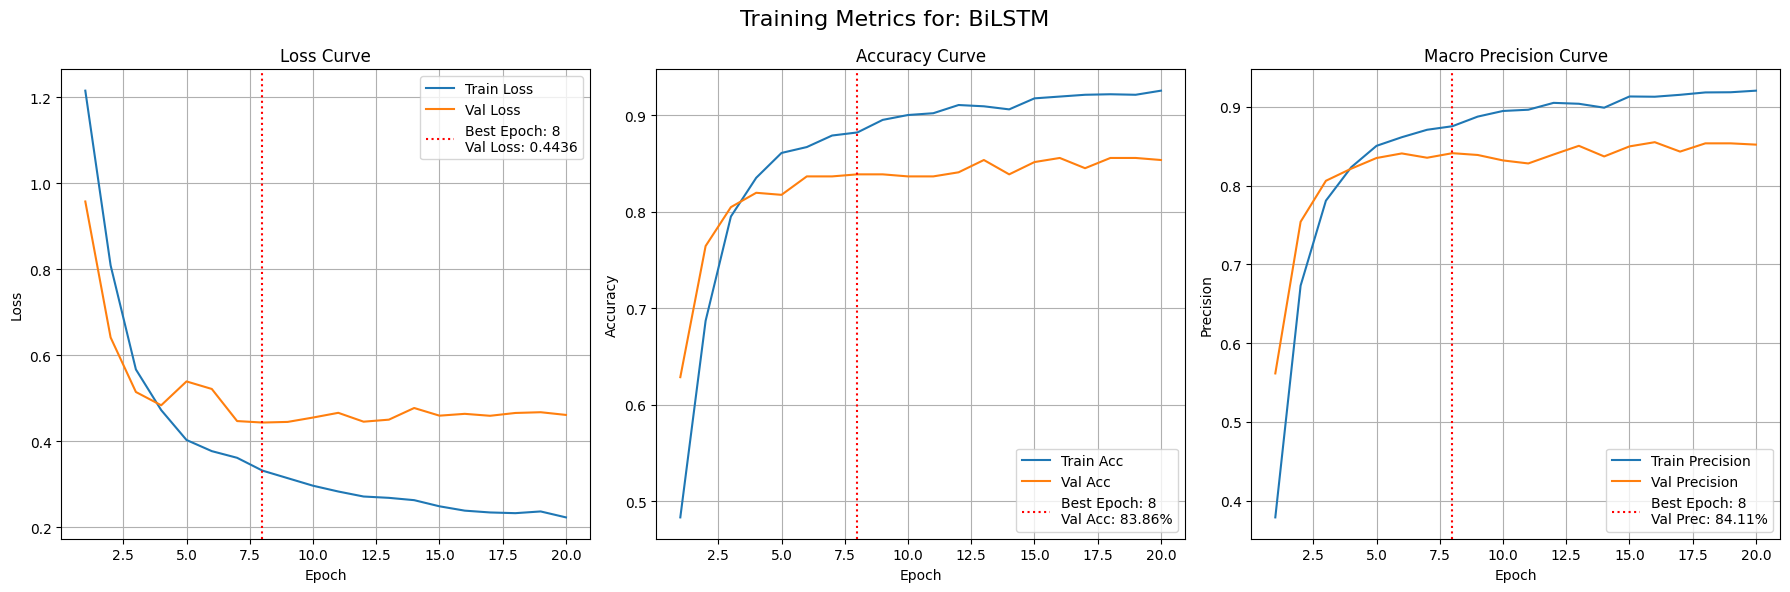

Matthews correlation coefficient: 0.7707407943915655
-------------------------------------

Classification Report:
                 precision    recall  f1-score   support

        GENERAL       0.84      0.93      0.88       190
LIGHT_PROFANITY       0.82      0.70      0.76        94
 HIGH_PROFANITY       0.87      0.77      0.81        60
       VIOLENCE       0.83      0.84      0.84       127

       accuracy                           0.84       471
      macro avg       0.84      0.81      0.82       471
   weighted avg       0.84      0.84      0.84       471



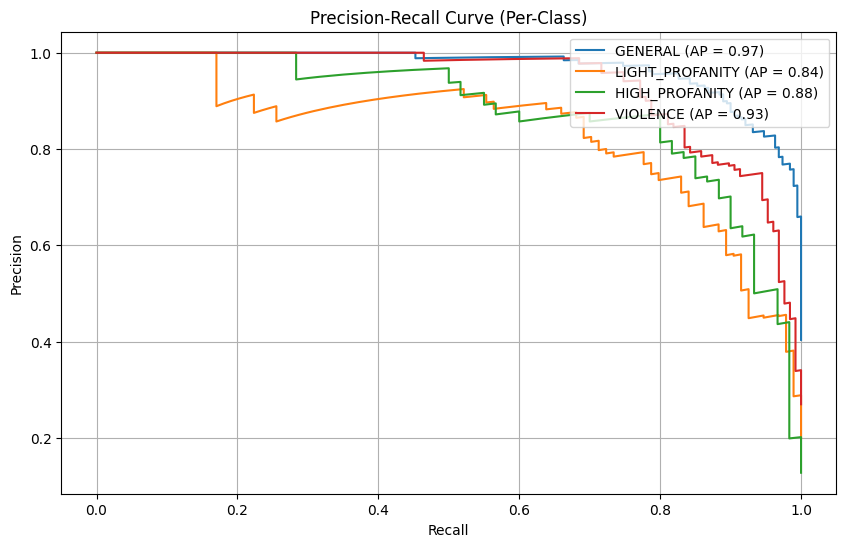

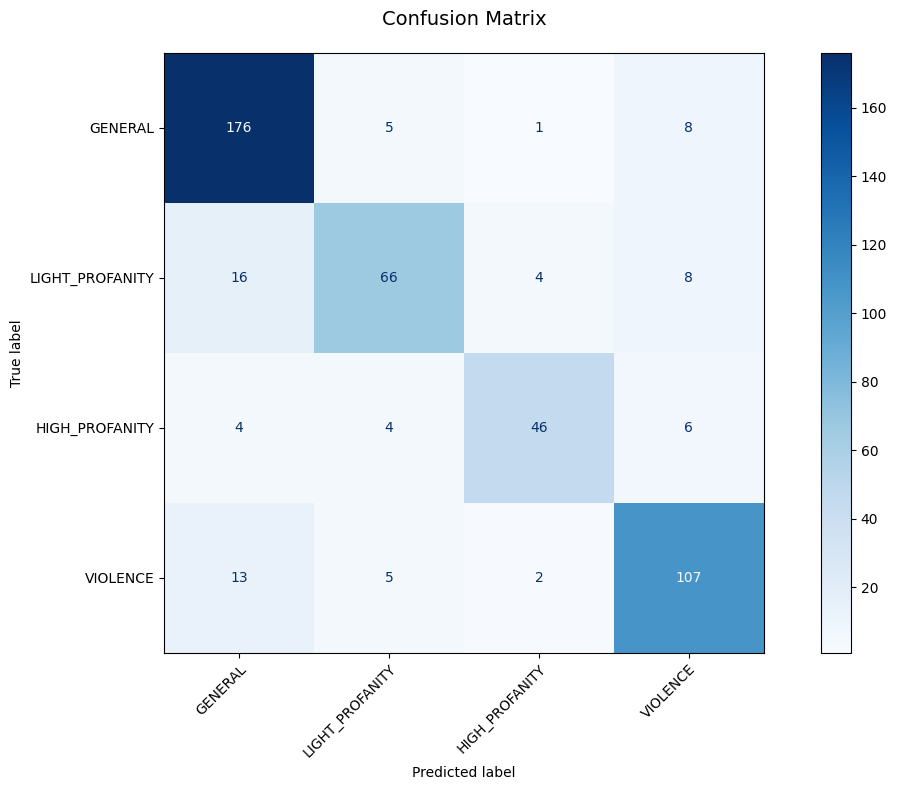

In [24]:
BiLSTM, BiLSTM_train_losses, BiLSTM_val_losses = model_train(BiLSTM, BiLSTM_criterion, BiLSTM_optimizer, train_loader, val_loader, scheduler=BiLSTM_scheduler, save_name="BiLSTM", epochs=BiLSTM_params["epochs"])
evaluate_model(BiLSTM, val_loader, label_map)

Matthews correlation coefficient: 0.7726444465734059
-------------------------------------

Classification Report:
                 precision    recall  f1-score   support

        GENERAL       0.83      0.93      0.88       189
LIGHT_PROFANITY       0.79      0.74      0.77        94
 HIGH_PROFANITY       0.81      0.83      0.82        60
       VIOLENCE       0.91      0.77      0.84       128

       accuracy                           0.84       471
      macro avg       0.83      0.82      0.83       471
   weighted avg       0.84      0.84      0.84       471

PR curve will be saved as BiLSTM_PR.png


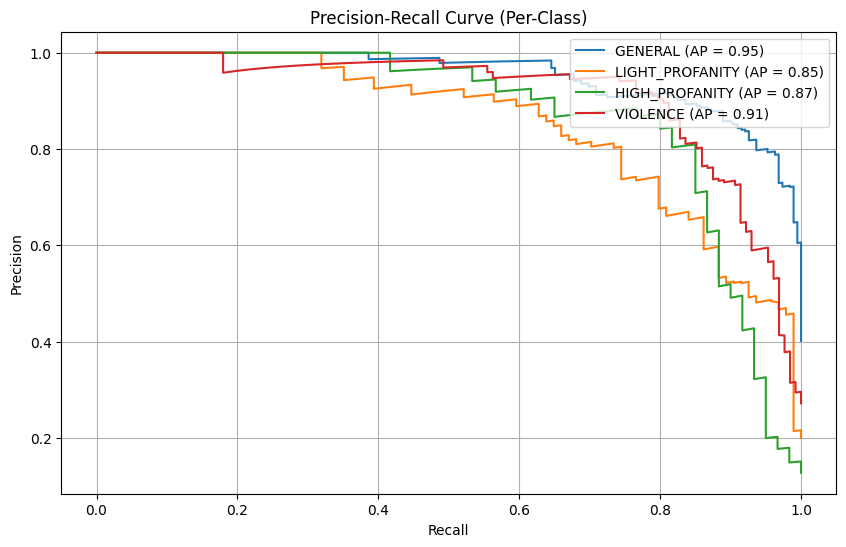

Confusion Matrix will be saved as BiLSTM_cm.png


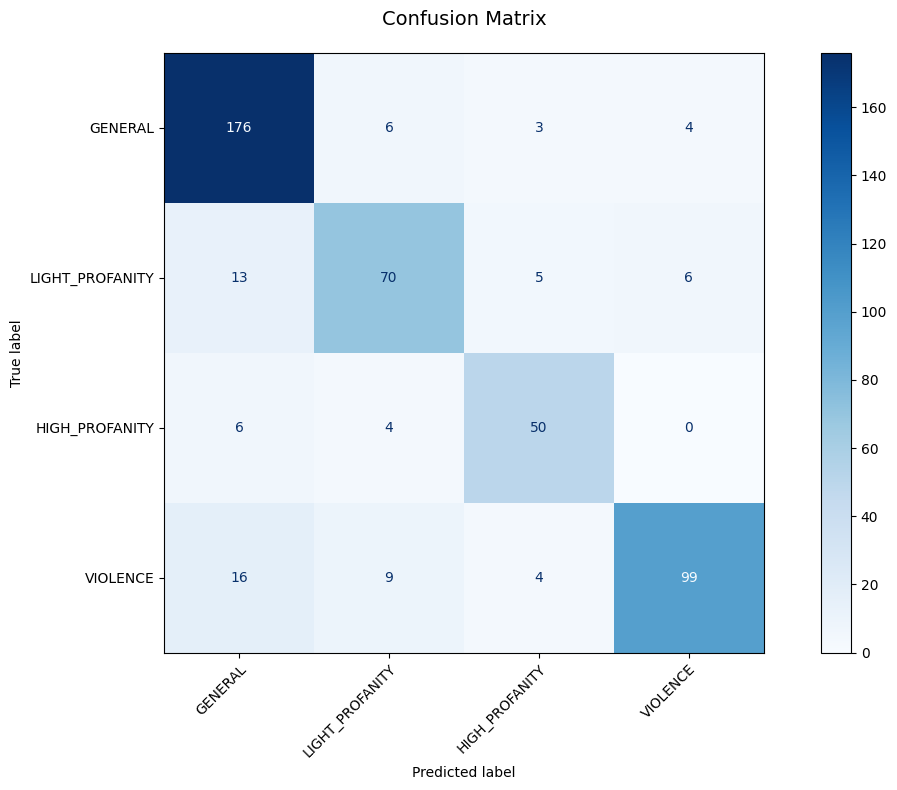

In [25]:
BiLSTM_report = evaluate_model(BiLSTM, test_loader, label_map, save_name="BiLSTM")

## Residual BiLSTM with Attention

In [26]:
print(BiLSTM)
print(type(BiLSTM))


BiLSTMAttn(
  (lstm): LSTM(300, 148, batch_first=True, bidirectional=True)
  (ln): LayerNorm((296,), eps=1e-05, elementwise_affine=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (attn): Linear(in_features=296, out_features=1, bias=True)
  (fc): Linear(in_features=296, out_features=4, bias=True)
)
<class '__main__.BiLSTMAttn'>


In [27]:
ResBiLSTM_params = {
    "input_dim" : embeddings_size,
    "hidden_dim" : 148,
    "num_classes" : num_classes,
    "num_layers" : 1,
    "bidirectional" : True,
    "lr" : 5e-5,
    "weight_decay" : 5e-4,
    "train_batch_size" : 16,
    "test_batch_size" : 16,
    "val_batch_size" : 16,
    "dropout" : 0.5,
    "warmup_ratio" : 0.1,
    "epochs" : 20,
    "label_smoothing" : 0,
    "early_stopping_patience" : 3,
    "lstm_dropout" : 0
}

ResBiLSTM = BiLSTMAttn(
    input_dim=ResBiLSTM_params["input_dim"],
    hidden_dim=ResBiLSTM_params["hidden_dim"],
    num_classes=ResBiLSTM_params["num_classes"],
    num_layers= ResBiLSTM_params["num_layers"],
    dropout=ResBiLSTM_params["dropout"],
    lstm_dropout=ResBiLSTM_params["lstm_dropout"],
    bidirectional=ResBiLSTM_params["bidirectional"],
    residual=True
).to(device)

# Loss function
ResBiLSTM_criterion = nn.CrossEntropyLoss(label_smoothing=ResBiLSTM_params["label_smoothing"])

# Optimizer using unpacking
ResBiLSTM_optimizer = torch.optim.AdamW(
    ResBiLSTM.parameters(),
    lr=ResBiLSTM_params["lr"],
    weight_decay=ResBiLSTM_params["weight_decay"]
)

res_total_steps = len(train_loader) * ResBiLSTM_params["epochs"]
res_warmup_steps = int(ResBiLSTM_params["warmup_ratio"] * res_total_steps)

ResBiLSTM_scheduler = get_linear_warmup_scheduler(
    ResBiLSTM_optimizer, warmup_steps=res_warmup_steps, total_steps=res_total_steps
)

res_train_loader = DataLoader(finetuned_train, batch_size=ResBiLSTM_params["train_batch_size"], shuffle=True, pin_memory=True, num_workers = 0)
res_test_loader = DataLoader(finetuned_test, batch_size=ResBiLSTM_params["test_batch_size"], shuffle=True, pin_memory=True, num_workers = 0)
res_val_loader = DataLoader(finetuned_val, batch_size=ResBiLSTM_params["val_batch_size"], shuffle=True, pin_memory=True, num_workers = 0)

print(ResBiLSTM)
print("\n----------------------------------------------------\n")
print(count_parameters(ResBiLSTM))

BiLSTMAttn(
  (lstm): ResLSTM(
    (dropout_layer): Dropout(p=0, inplace=False)
    (forward_cells): ModuleList(
      (0): ResLSTMLayer(
        (cell): ResLSTMCell(
          (ln_ry): RecursiveScriptModule(original_name=LayerNorm)
          (ln_res): RecursiveScriptModule(original_name=LayerNorm)
        )
      )
    )
    (backward_cells): ModuleList(
      (0): ResLSTMLayer(
        (cell): ResLSTMCell(
          (ln_ry): RecursiveScriptModule(original_name=LayerNorm)
          (ln_res): RecursiveScriptModule(original_name=LayerNorm)
        )
      )
    )
  )
  (ln): LayerNorm((296,), eps=1e-05, elementwise_affine=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (attn): Linear(in_features=296, out_features=1, bias=True)
  (fc): Linear(in_features=296, out_features=4, bias=True)
)

----------------------------------------------------

623677


Epoch 1/20 | Train Loss: 1.3494 | Val Loss: 1.1268 | Train Acc: 36.23% | Val Acc: 55.84%
Epoch 2/20 | Train Loss: 0.9904 | Val Loss: 0.7976 | Train Acc: 60.96% | Val Acc: 68.58%
Epoch 3/20 | Train Loss: 0.7419 | Val Loss: 0.6534 | Train Acc: 72.40% | Val Acc: 74.52%
Epoch 4/20 | Train Loss: 0.6043 | Val Loss: 0.5764 | Train Acc: 78.09% | Val Acc: 78.56%
Epoch 5/20 | Train Loss: 0.5269 | Val Loss: 0.5442 | Train Acc: 80.74% | Val Acc: 80.25%
Epoch 6/20 | Train Loss: 0.4791 | Val Loss: 0.5185 | Train Acc: 83.29% | Val Acc: 81.32%
Epoch 7/20 | Train Loss: 0.4310 | Val Loss: 0.5046 | Train Acc: 84.59% | Val Acc: 82.80%
Epoch 8/20 | Train Loss: 0.4071 | Val Loss: 0.4964 | Train Acc: 85.13% | Val Acc: 82.59%
Epoch 9/20 | Train Loss: 0.3803 | Val Loss: 0.5096 | Train Acc: 86.77% | Val Acc: 83.65%
Epoch 10/20 | Train Loss: 0.3489 | Val Loss: 0.4741 | Train Acc: 87.92% | Val Acc: 83.44%
Epoch 11/20 | Train Loss: 0.3323 | Val Loss: 0.5008 | Train Acc: 88.90% | Val Acc: 83.44%
Epoch 12/20 | Train

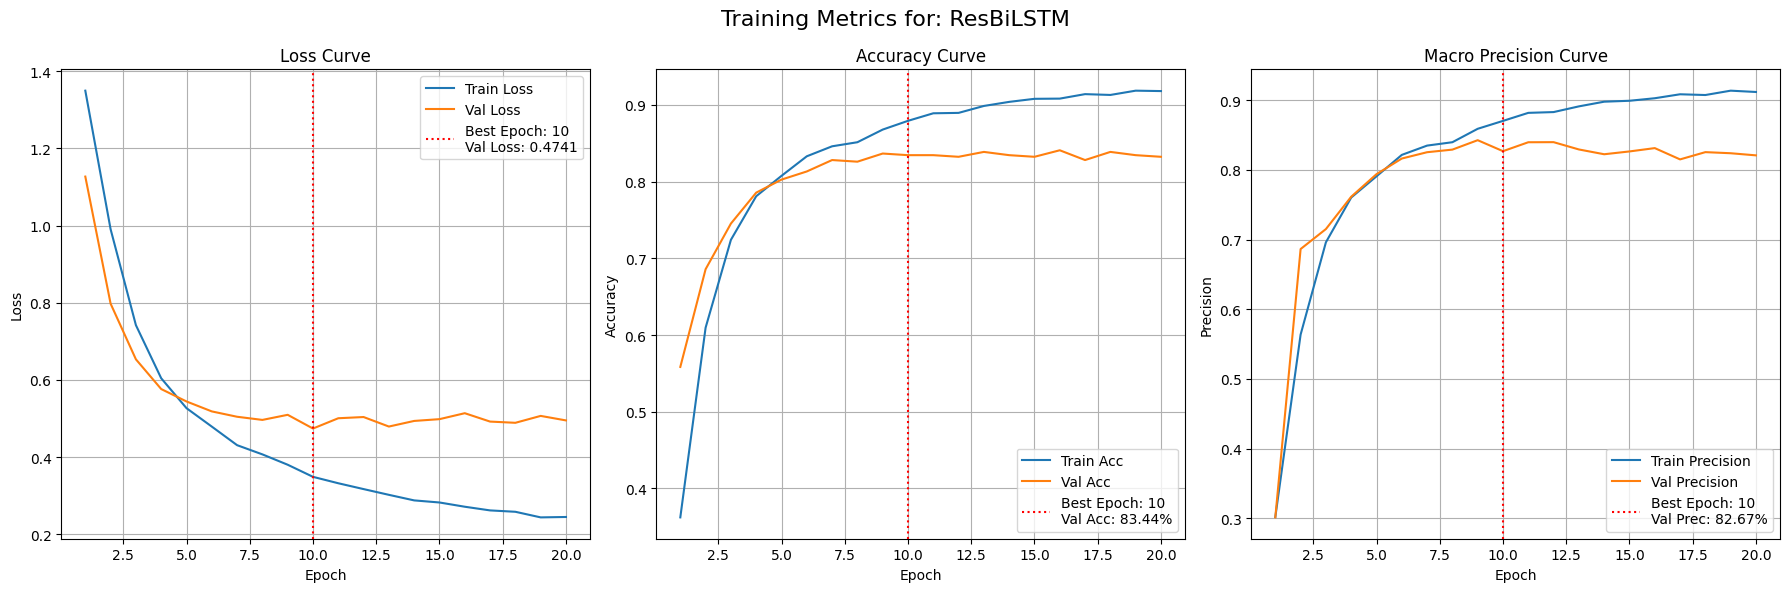

In [28]:
ResBiLSTM, ResBiLSTM_train_losses, ResBiLSTM_val_losses = model_train(ResBiLSTM, ResBiLSTM_criterion, ResBiLSTM_optimizer, res_train_loader, res_val_loader, scheduler=ResBiLSTM_scheduler, save_name="ResBiLSTM", epochs=ResBiLSTM_params["epochs"])


Matthews correlation coefficient: 0.7646354449764058
-------------------------------------

Classification Report:
                 precision    recall  f1-score   support

        GENERAL       0.84      0.94      0.89       190
LIGHT_PROFANITY       0.74      0.73      0.74        94
 HIGH_PROFANITY       0.83      0.65      0.73        60
       VIOLENCE       0.89      0.84      0.87       127

       accuracy                           0.83       471
      macro avg       0.83      0.79      0.81       471
   weighted avg       0.83      0.83      0.83       471



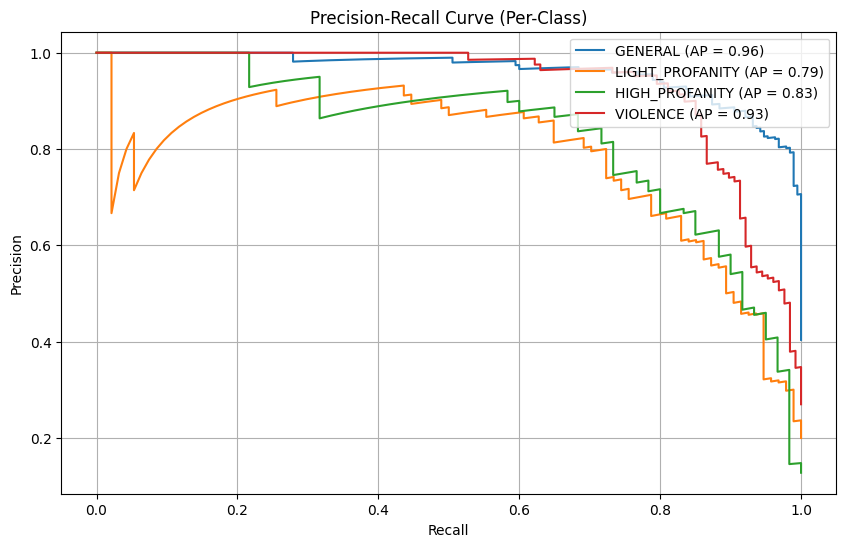

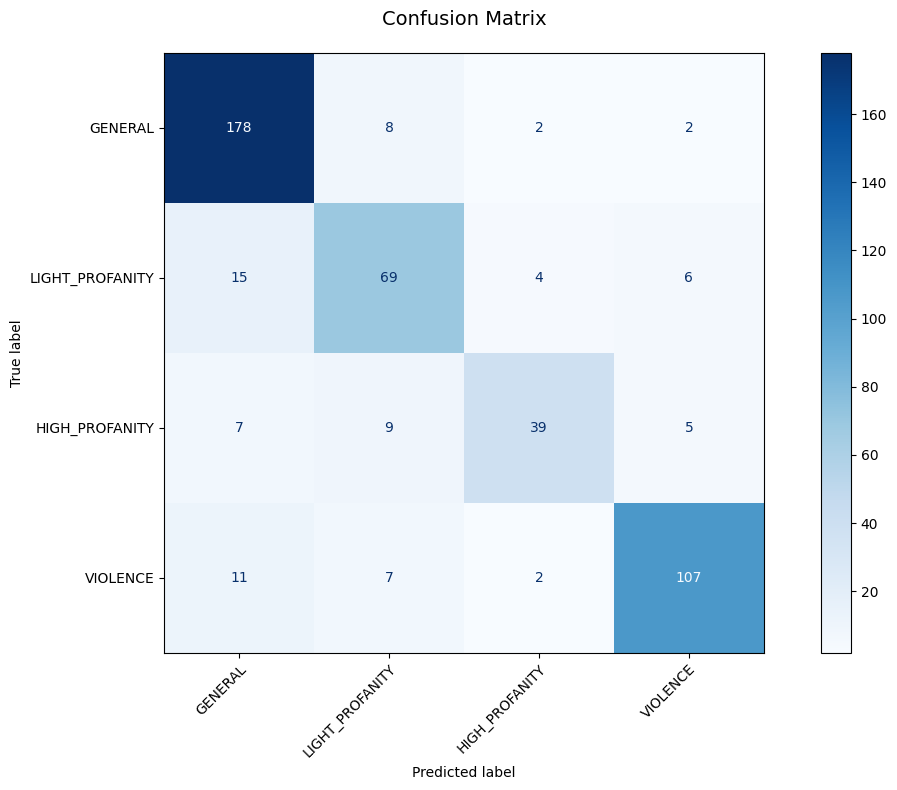

In [29]:
evaluate_model(ResBiLSTM, val_loader, label_map)

Matthews correlation coefficient: 0.7361731675185311
-------------------------------------

Classification Report:
                 precision    recall  f1-score   support

        GENERAL       0.82      0.92      0.87       189
LIGHT_PROFANITY       0.73      0.71      0.72        94
 HIGH_PROFANITY       0.78      0.78      0.78        60
       VIOLENCE       0.88      0.75      0.81       128

       accuracy                           0.81       471
      macro avg       0.80      0.79      0.80       471
   weighted avg       0.82      0.81      0.81       471

PR curve will be saved as ResBiLSTM_PR.png


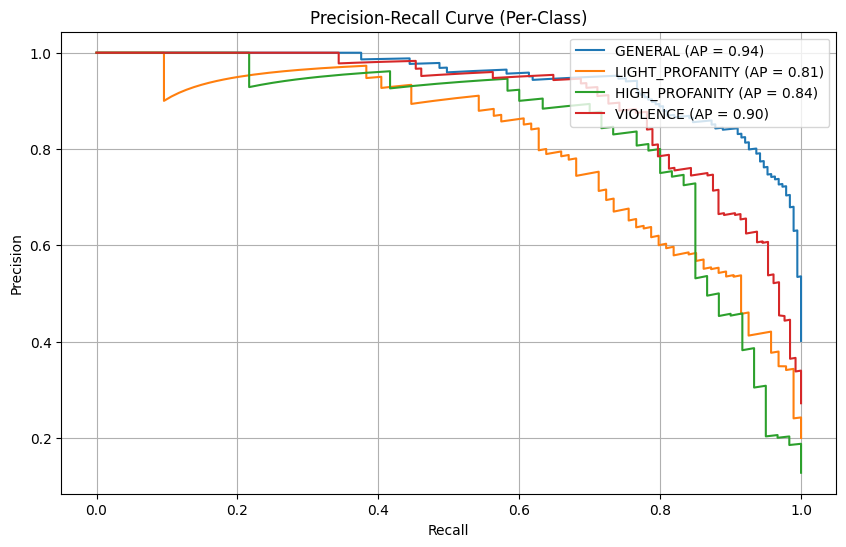

Confusion Matrix will be saved as ResBiLSTM_cm.png


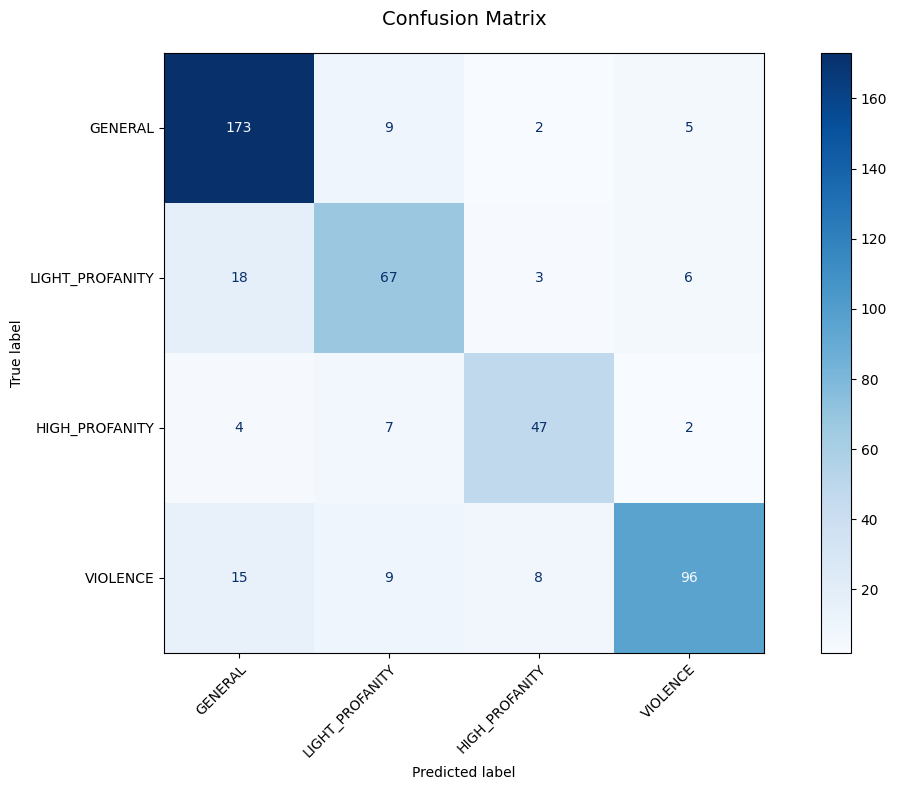

In [30]:
ResBiLSTM_report = evaluate_model(ResBiLSTM, test_loader, label_map, save_name="ResBiLSTM")

## Bilstm with fasttext input as post attention

In [31]:
# First we need the dataset to contain mean of fasttext embeddings, sequence embeddings, mask 
class ModifiedDataset(Dataset):
    def __init__(self, original_dataset):
        self.original_dataset = original_dataset
    
    def __len__(self):
        return len(self.original_dataset)
    
    def __getitem__(self, idx):
        item = self.original_dataset[idx]
        
        features, mask, label = item
        
        if mask.dtype != torch.bool:
            mask = mask.bool() 

        filtered_features = features[mask]
        mean_features = torch.mean(filtered_features, dim=0)
            
        return (features, mean_features, mask, label)

train2 = ModifiedDataset(finetuned_train)
test2 = ModifiedDataset(finetuned_test)
val2 = ModifiedDataset(finetuned_val)

In [36]:
# Supports both residual and plain lstm
class BiLSTMAttn2(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes, num_layers=1, dropout=0.5, bidirectional=True):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim,num_layers=num_layers, batch_first=True, bidirectional=bidirectional) 
        self.direction = 2 if bidirectional else 1
        self.ln = nn.LayerNorm(hidden_dim * self.direction)
        self.dropout = nn.Dropout(dropout)
        self.attn = nn.Linear(hidden_dim * self.direction, 1) # since BiLSTM
        self.proj = nn.Linear(input_dim, hidden_dim * self.direction)
        self.fc1 = nn.Linear(hidden_dim * self.direction, hidden_dim * self.direction)
        self.fc2 = nn.Linear(hidden_dim * self.direction, num_classes)

    def forward(self, x, x_mean, mask):
        lstm_out, _ = self.lstm(x)  # (Batch, SequenceLength, 2 * Hidden Dim)
        lstm_out = self.ln(lstm_out)  # Normalize
        lstm_out = self.dropout(lstm_out)  # Dropout

        # Attention scores
        scores = self.attn(lstm_out).squeeze(-1)  # (B, L)

        # Mask padding positions
        scores = scores.masked_fill(~mask, float('-inf'))  # invalid positions → -inf

        attn_weights = torch.softmax(scores, dim=1)  # (B, L)
        attn_weights = attn_weights.unsqueeze(-1)   # (B, L, 1)

        # Weighted sum
        context = torch.sum(attn_weights * lstm_out, dim=1)  # (B, 2H)
        context = self.ln(context) # normalize before adding

        # Handling x_mean to shape (B, 2H)
        x_mean_proj = self.proj(x_mean)

        # Adding two tensors
        fused = context + x_mean_proj 
        fused = self.fc1(fused)
        fused = self.ln(fused)
        fused = self.dropout(fused)
        
        logits = self.fc2(fused)  # (B, num_classes)

        return logits, attn_weights

BiLSTM2_params = {
    "input_dim" : embeddings_size,
    "hidden_dim" : 148,
    "num_classes" : num_classes,
    "num_layers" : 1,
    "bidirectional" : True,
    "lr" : 1e-4,
    "weight_decay" : 1e-4,
    "train_batch_size" : 16,
    "test_batch_size" : 16,
    "val_batch_size" : 16,
    "dropout" : 0.5,
    "warmup_ratio" : 0.1,
    "epochs" : 20,
    "label_smoothing" : 0,
    "early_stopping_patience" : 3

}

BiLSTM2 = BiLSTMAttn2(
    input_dim=BiLSTM2_params["input_dim"],
    hidden_dim=BiLSTM2_params["hidden_dim"],
    num_classes=BiLSTM2_params["num_classes"],
    num_layers= BiLSTM2_params["num_layers"],
    dropout=BiLSTM2_params["dropout"],
    bidirectional=BiLSTM2_params["bidirectional"],
).to(device)

# Loss function
BiLSTM2_criterion = nn.CrossEntropyLoss(label_smoothing=BiLSTM2_params["label_smoothing"])

# Optimizer using unpacking
BiLSTM2_optimizer = torch.optim.AdamW(
    BiLSTM2.parameters(),
    lr=BiLSTM2_params["lr"],
    weight_decay=BiLSTM2_params["weight_decay"]
)

res_total_steps = len(train_loader) * BiLSTM2_params["epochs"]
res_warmup_steps = int(BiLSTM2_params["warmup_ratio"] * res_total_steps)

BiLSTM2_scheduler = get_linear_warmup_scheduler(
    BiLSTM2_optimizer, warmup_steps=res_warmup_steps, total_steps=res_total_steps
)

train_loader2 = DataLoader(train2, batch_size=BiLSTM2_params["train_batch_size"], shuffle=True, pin_memory=True, num_workers = 0)
test_loader2 = DataLoader(test2, batch_size=BiLSTM2_params["test_batch_size"], shuffle=True, pin_memory=True, num_workers = 0)
val_loader2 = DataLoader(val2, batch_size=BiLSTM2_params["val_batch_size"], shuffle=True, pin_memory=True, num_workers = 0)

print(BiLSTM2)
print("\n----------------------------------------------------\n")
print(count_parameters(BiLSTM2))

BiLSTMAttn2(
  (lstm): LSTM(300, 148, batch_first=True, bidirectional=True)
  (ln): LayerNorm((296,), eps=1e-05, elementwise_affine=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (attn): Linear(in_features=296, out_features=1, bias=True)
  (proj): Linear(in_features=300, out_features=296, bias=True)
  (fc1): Linear(in_features=296, out_features=296, bias=True)
  (fc2): Linear(in_features=296, out_features=4, bias=True)
)

----------------------------------------------------

711885


Epoch 1/20 | Train Loss: 1.2934 | Val Loss: 0.8814 | Train Acc: 42.63% | Val Acc: 66.03%
Epoch 2/20 | Train Loss: 0.8318 | Val Loss: 0.5790 | Train Acc: 66.19% | Val Acc: 77.49%
Epoch 3/20 | Train Loss: 0.5914 | Val Loss: 0.5462 | Train Acc: 78.41% | Val Acc: 78.56%
Epoch 4/20 | Train Loss: 0.5143 | Val Loss: 0.4600 | Train Acc: 82.58% | Val Acc: 83.23%
Epoch 5/20 | Train Loss: 0.4479 | Val Loss: 0.4939 | Train Acc: 84.44% | Val Acc: 84.29%
Epoch 6/20 | Train Loss: 0.4147 | Val Loss: 0.4680 | Train Acc: 85.82% | Val Acc: 84.08%
Epoch 7/20 | Train Loss: 0.3908 | Val Loss: 0.4388 | Train Acc: 87.44% | Val Acc: 85.35%
Epoch 8/20 | Train Loss: 0.3620 | Val Loss: 0.4904 | Train Acc: 87.73% | Val Acc: 83.86%
Epoch 9/20 | Train Loss: 0.3379 | Val Loss: 0.4583 | Train Acc: 88.69% | Val Acc: 86.20%
Epoch 10/20 | Train Loss: 0.3229 | Val Loss: 0.4550 | Train Acc: 88.84% | Val Acc: 85.14%
Epoch 11/20 | Train Loss: 0.3159 | Val Loss: 0.4832 | Train Acc: 89.43% | Val Acc: 85.99%
Epoch 12/20 | Train

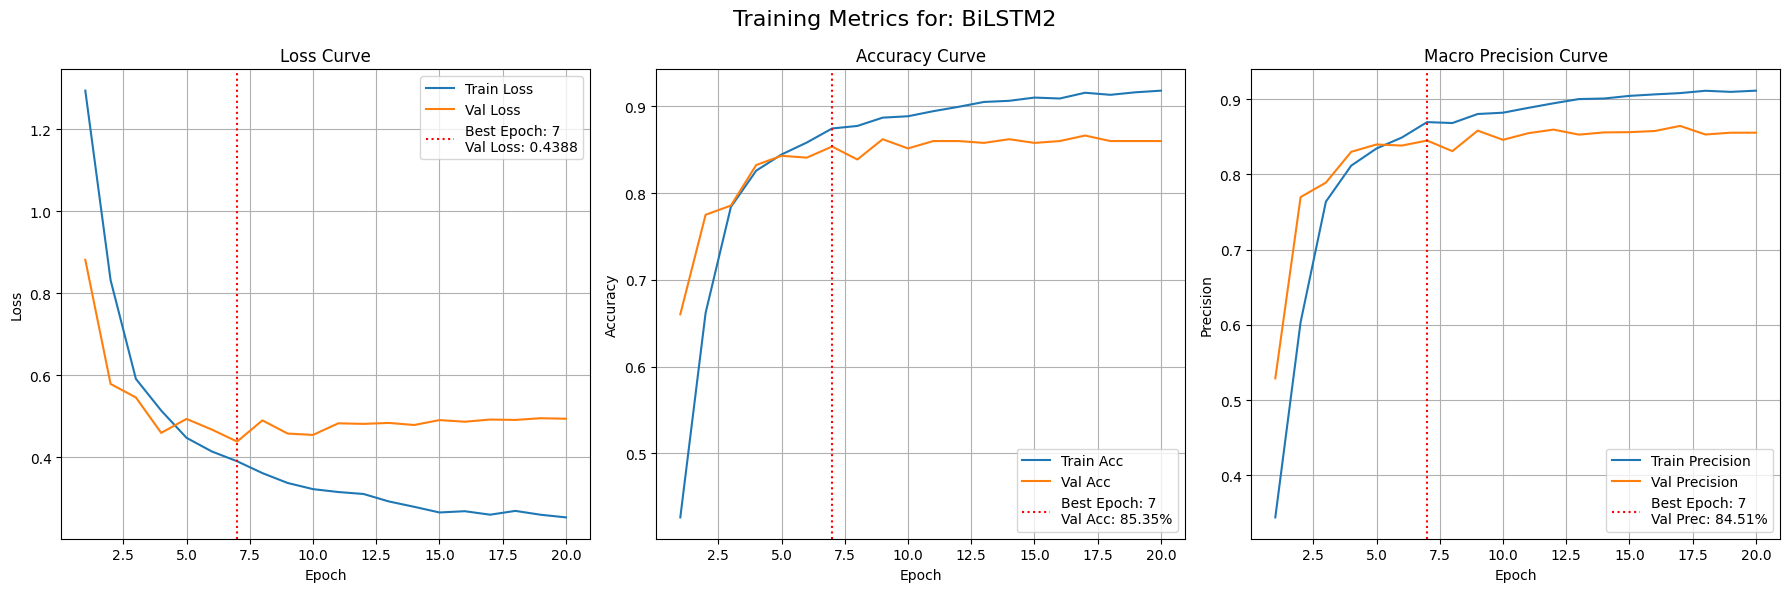

In [37]:
BiLSTM2, BiLSTM2_train_losses, BiLSTM2_val_losses = model_train(BiLSTM2, BiLSTM2_criterion, BiLSTM2_optimizer, train_loader2, val_loader2, scheduler=BiLSTM2_scheduler, save_name="BiLSTM2", epochs=BiLSTM2_params["epochs"], model2=True)


Matthews correlation coefficient: 0.7920971771556804
-------------------------------------

Classification Report:
                 precision    recall  f1-score   support

        GENERAL       0.88      0.93      0.91       190
LIGHT_PROFANITY       0.83      0.74      0.79        94
 HIGH_PROFANITY       0.83      0.75      0.79        60
       VIOLENCE       0.83      0.87      0.85       127

       accuracy                           0.85       471
      macro avg       0.85      0.82      0.83       471
   weighted avg       0.85      0.85      0.85       471



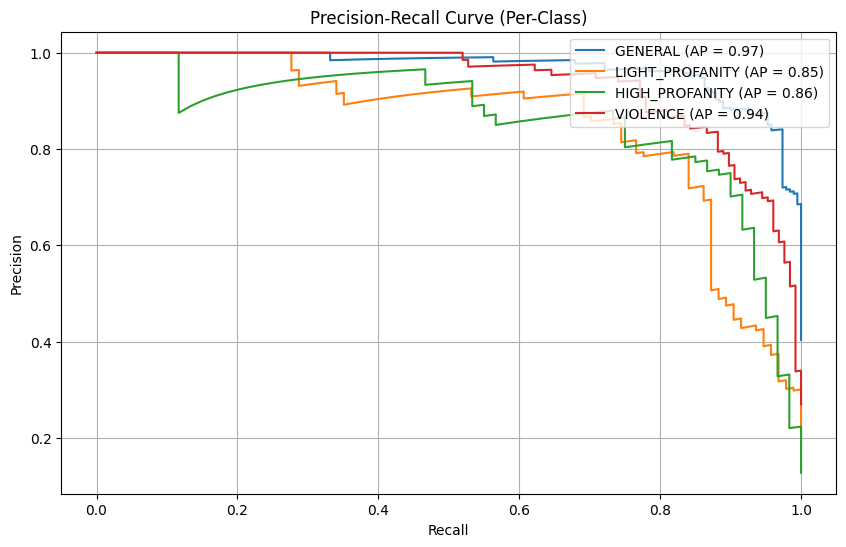

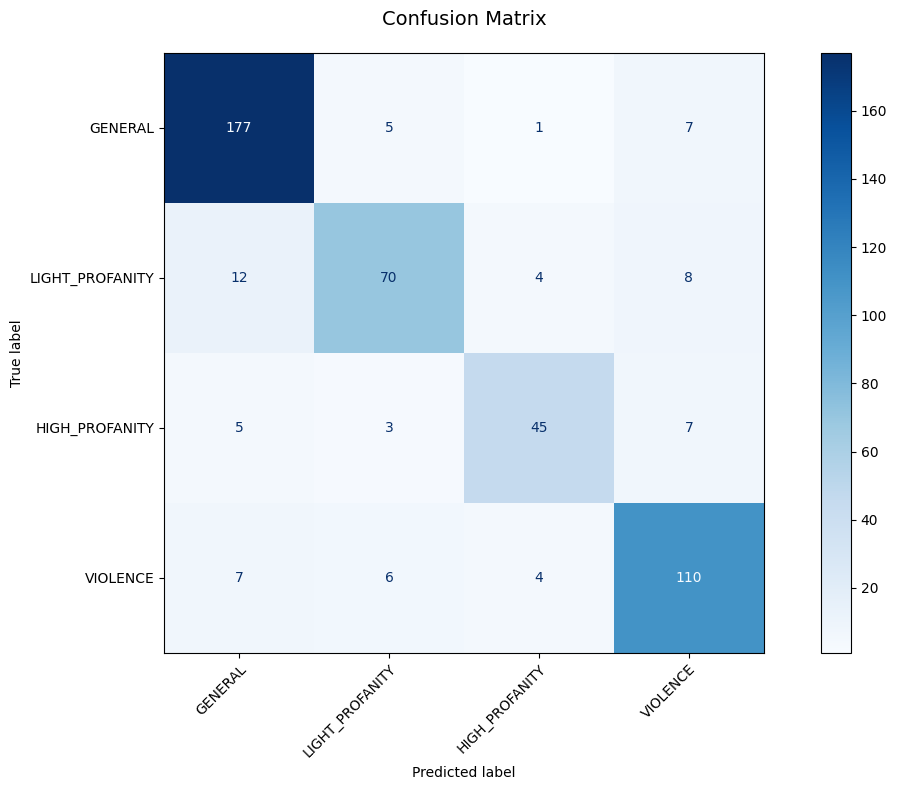

In [39]:
evaluate_model(BiLSTM2, val_loader2, label_map, model2=True)

Matthews correlation coefficient: 0.742454235772807
-------------------------------------

Classification Report:
                 precision    recall  f1-score   support

        GENERAL       0.84      0.88      0.86       189
LIGHT_PROFANITY       0.74      0.72      0.73        94
 HIGH_PROFANITY       0.75      0.80      0.77        60
       VIOLENCE       0.87      0.80      0.83       128

       accuracy                           0.82       471
      macro avg       0.80      0.80      0.80       471
   weighted avg       0.82      0.82      0.82       471

PR curve will be saved as BiLSTM2_PR.png


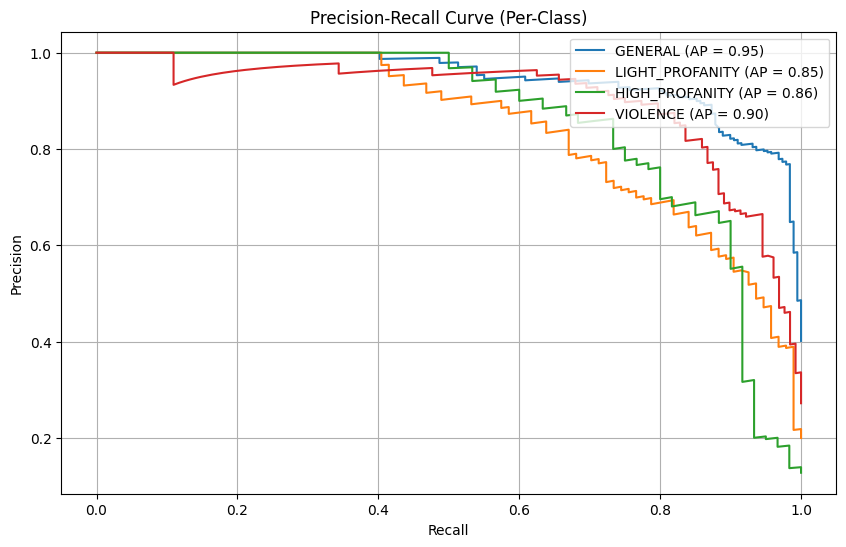

Confusion Matrix will be saved as BiLSTM2_cm.png


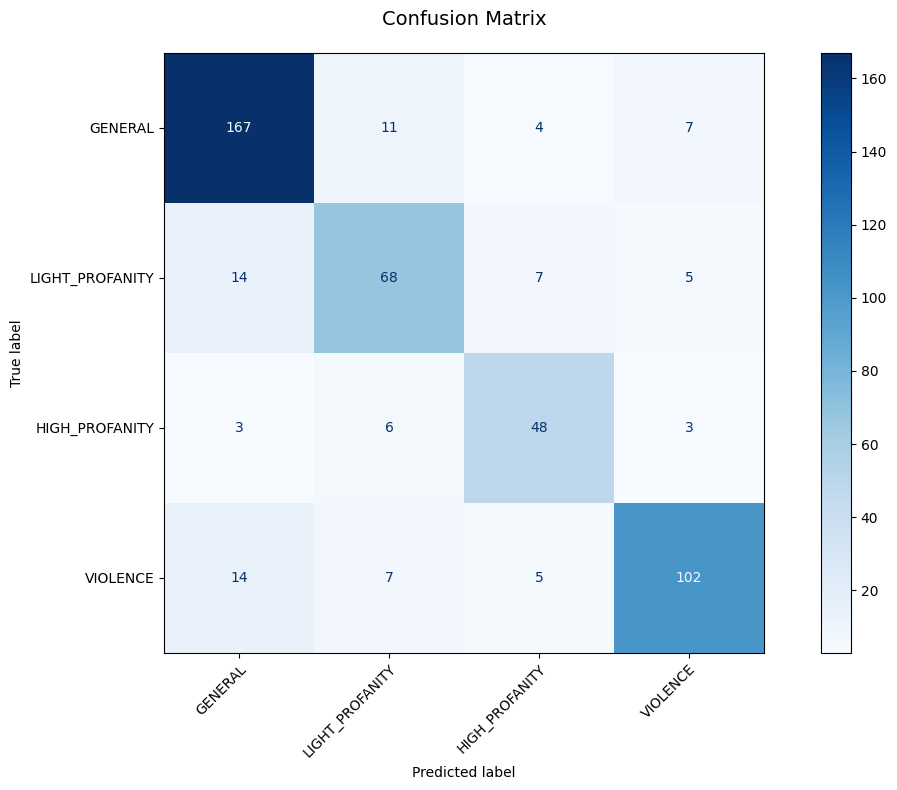

In [41]:
BiLSTM2_report = evaluate_model(BiLSTM2, test_loader2, label_map, save_name="BiLSTM2", model2=True)

## Previous residual LSTM

In [17]:
# Previous Residual LSTM implementation 
shutil.copy(Path("/kaggle/input/pretrained-fasttext/lstm_prev.py"), Path("./"))

from lstm_prev import ResLSTM as ResLSTM_previous
from torch.optim.lr_scheduler import CosineAnnealingLR

In [18]:
class ResBiLSTMAttn_prev(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes, num_layers=1, dropout=0.5, bidirectional=True):
        super().__init__()
        self.lstm = ResLSTM_previous(input_dim, hidden_dim,num_layers, batch_first=True, bidirectional = bidirectional)
        self.ln = nn.LayerNorm(hidden_dim * 2)
        self.dropout = nn.Dropout(dropout)
        self.attn = nn.Linear(hidden_dim*2 , 1)
        self.fc = nn.Linear(hidden_dim *2, num_classes)

    def forward(self, x, mask):
        lstm_out, _ = self.lstm(x)  # (Batch, SequenceLength, 2 * Hidden Dim)
        lstm_out = self.ln(lstm_out)  # Normalize
        lstm_out = self.dropout(lstm_out)  # Dropout

        # Attention scores
        scores = self.attn(lstm_out).squeeze(-1)  # (B, L)

        # Mask padding positions
        scores = scores.masked_fill(~mask, float('-inf'))  # invalid positions → -inf

        attn_weights = torch.softmax(scores, dim=1)  # (B, L)
        attn_weights = attn_weights.unsqueeze(-1)   # (B, L, 1)

        # Weighted sum
        context = torch.sum(attn_weights * lstm_out, dim=1)  # (B, 2H)
        context = self.ln(context) # normalize before FC
        logits = self.fc(context)  # (B, num_classes)

        return logits, attn_weights

In [27]:
ResBiLSTM_prev_params = {
   "input_dim" : embeddings_size,
    "hidden_dim" : 148,
    "num_classes" : num_classes,
    "num_layers" : 1,
    "bidirectional" : True,
    "lr" : 1e-4,
    "weight_decay" : 1e-4,
    "train_batch_size" : 16,
    "test_batch_size" : 16,
    "val_batch_size" : 16,
    "dropout" : 0.4,
    "warmup_ratio" : 0.1,
    "epochs" : 20,
    "label_smoothing" : 0,
    "early_stopping_patience" : 3,
    "lstm_dropout" : 0
}

ResBiLSTM_prev = ResBiLSTMAttn_prev(
    input_dim=ResBiLSTM_prev_params["input_dim"],
    hidden_dim=ResBiLSTM_prev_params["hidden_dim"],
    num_classes=ResBiLSTM_prev_params["num_classes"],
    num_layers= ResBiLSTM_prev_params["num_layers"],
    dropout=ResBiLSTM_prev_params["dropout"],
    bidirectional=ResBiLSTM_prev_params["bidirectional"],
).to(device)

# Loss function
ResBiLSTM_prev_criterion = nn.CrossEntropyLoss(label_smoothing=ResBiLSTM_prev_params["label_smoothing"])

# Optimizer using unpacking
ResBiLSTM_prev_optimizer = torch.optim.AdamW(
    ResBiLSTM_prev.parameters(),
    lr=ResBiLSTM_prev_params["lr"],
    weight_decay=ResBiLSTM_prev_params["weight_decay"]
)


ResBiLSTM_prev_scheduler = CosineAnnealingLR(ResBiLSTM_prev_optimizer, T_max=len(train_loader) * ResBiLSTM_prev_params["epochs"])

print(ResBiLSTM_prev)
print("\n----------------------------------------------------\n")
print(count_parameters(ResBiLSTM_prev))


ResBiLSTMAttn_prev(
  (lstm): ResLSTM(
    (dropout_layer): Dropout(p=0, inplace=False)
    (forward_cells): ModuleList(
      (0): ResLSTMLayer(
        (cell): ResLSTMCell()
      )
    )
    (backward_cells): ModuleList(
      (0): ResLSTMLayer(
        (cell): ResLSTMCell()
      )
    )
  )
  (ln): LayerNorm((296,), eps=1e-05, elementwise_affine=True)
  (dropout): Dropout(p=0.4, inplace=False)
  (attn): Linear(in_features=296, out_features=1, bias=True)
  (fc): Linear(in_features=296, out_features=4, bias=True)
)

----------------------------------------------------

666893


Epoch 1/20 | Train Loss: 1.5834 | Val Loss: 1.5821 | Train Acc: 20.11% | Val Acc: 21.02%
Epoch 2/20 | Train Loss: 1.5773 | Val Loss: 1.5630 | Train Acc: 20.66% | Val Acc: 20.38%
Epoch 3/20 | Train Loss: 1.5738 | Val Loss: 1.6246 | Train Acc: 20.77% | Val Acc: 16.56%
Epoch 4/20 | Train Loss: 1.5964 | Val Loss: 1.6222 | Train Acc: 19.65% | Val Acc: 19.53%
Epoch 5/20 | Train Loss: 1.5795 | Val Loss: 1.5203 | Train Acc: 20.27% | Val Acc: 24.63%
Epoch 6/20 | Train Loss: 1.5848 | Val Loss: 1.5438 | Train Acc: 19.52% | Val Acc: 18.47%
Epoch 7/20 | Train Loss: 1.5841 | Val Loss: 1.5657 | Train Acc: 19.79% | Val Acc: 17.83%
Epoch 8/20 | Train Loss: 1.5774 | Val Loss: 1.5722 | Train Acc: 20.40% | Val Acc: 16.56%
Epoch 9/20 | Train Loss: 1.5813 | Val Loss: 1.6539 | Train Acc: 19.50% | Val Acc: 19.75%
Epoch 10/20 | Train Loss: 1.5947 | Val Loss: 1.4924 | Train Acc: 18.83% | Val Acc: 21.87%
Epoch 11/20 | Train Loss: 1.5962 | Val Loss: 1.5934 | Train Acc: 19.89% | Val Acc: 14.23%
Epoch 12/20 | Train

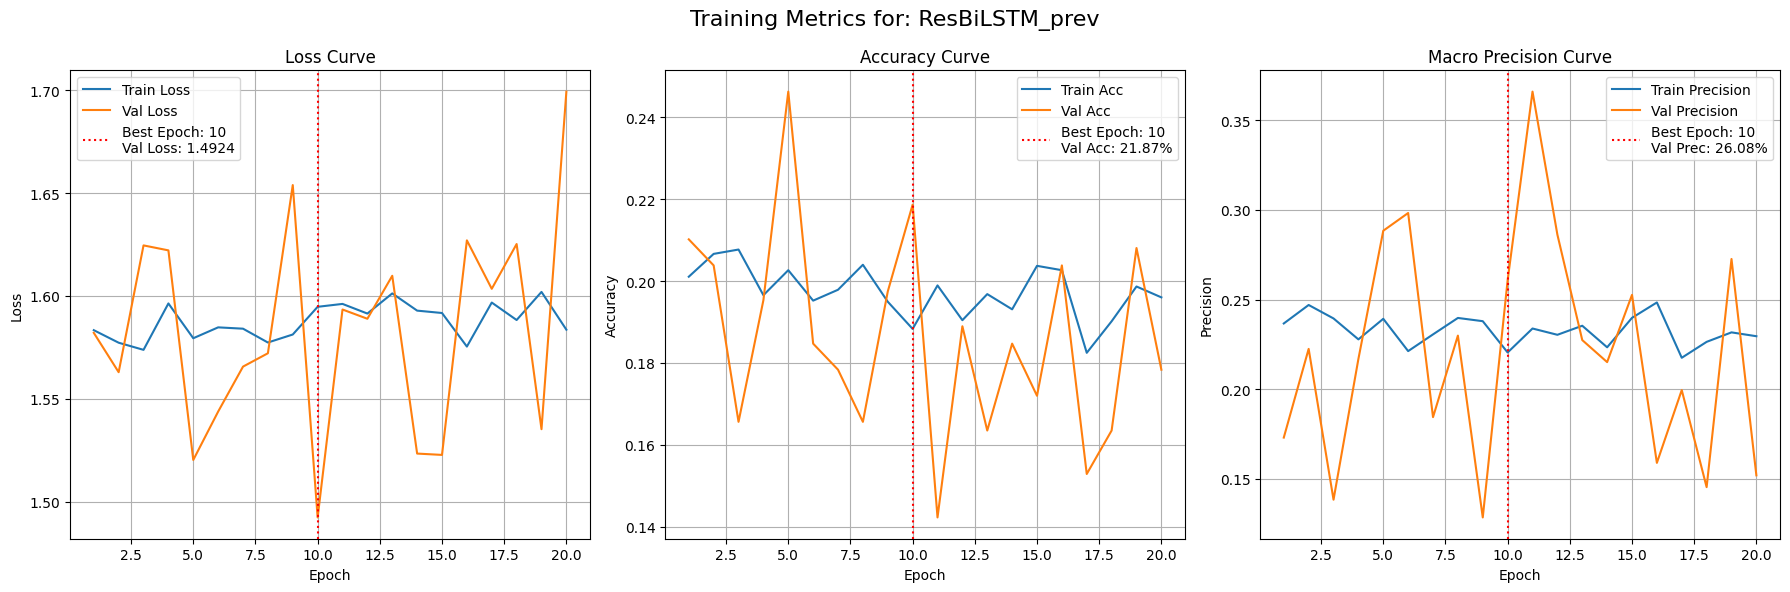

Matthews correlation coefficient: 0.006507496882775143
-------------------------------------

Classification Report:
                 precision    recall  f1-score   support

        GENERAL       0.39      0.17      0.24       190
LIGHT_PROFANITY       0.26      0.52      0.35        94
 HIGH_PROFANITY       0.07      0.20      0.10        60
       VIOLENCE       0.32      0.07      0.12       127

       accuracy                           0.22       471
      macro avg       0.26      0.24      0.20       471
   weighted avg       0.31      0.22      0.21       471



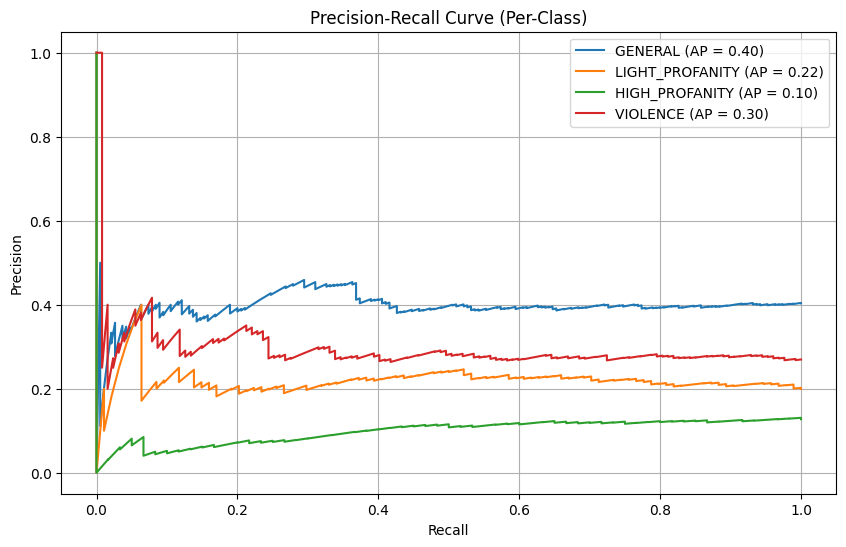

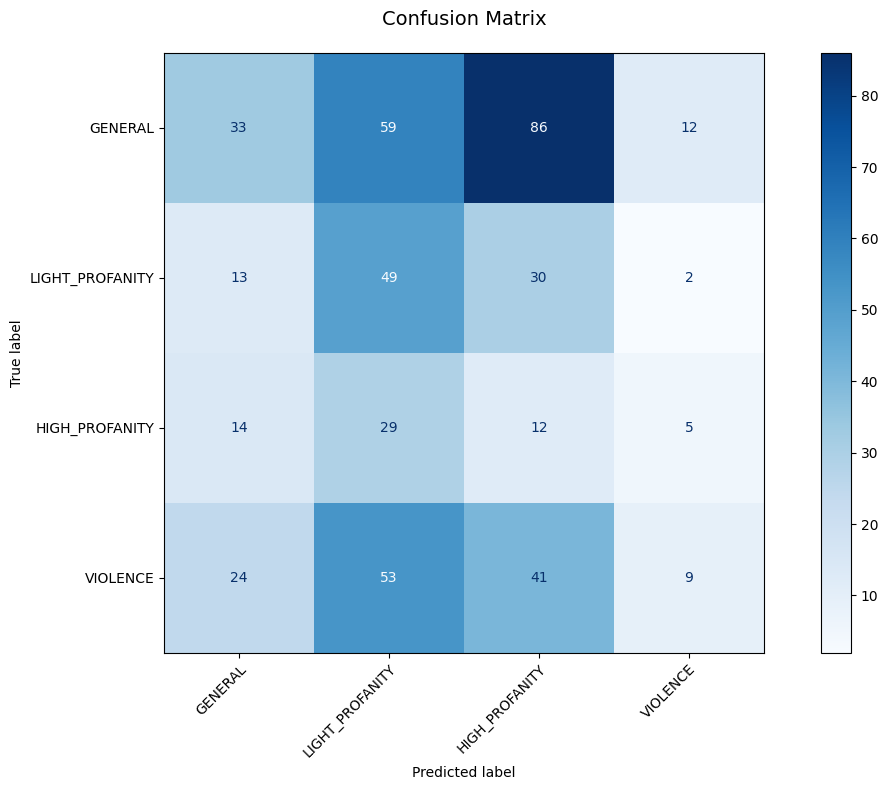

In [28]:
ResBiLSTM_prev, ResBiLSTM_prev_train_losses, ResBiLSTM_prev_val_losses = model_train(ResBiLSTM_prev, ResBiLSTM_prev_criterion, ResBiLSTM_prev_optimizer, train_loader, val_loader, scheduler=ResBiLSTM_prev_scheduler, save_name="ResBiLSTM_prev", epochs=ResBiLSTM_prev_params["epochs"])
evaluate_model(ResBiLSTM_prev, val_loader, label_map)

Matthews correlation coefficient: -0.026561029753689923
-------------------------------------

Classification Report:
                 precision    recall  f1-score   support

        GENERAL       0.40      0.14      0.21       189
LIGHT_PROFANITY       0.20      0.50      0.28        94
 HIGH_PROFANITY       0.07      0.15      0.09        60
       VIOLENCE       0.32      0.06      0.10       128

       accuracy                           0.19       471
      macro avg       0.25      0.21      0.17       471
   weighted avg       0.30      0.19      0.18       471

PR curve will be saved as ResBiLSTM_prev_PR.png


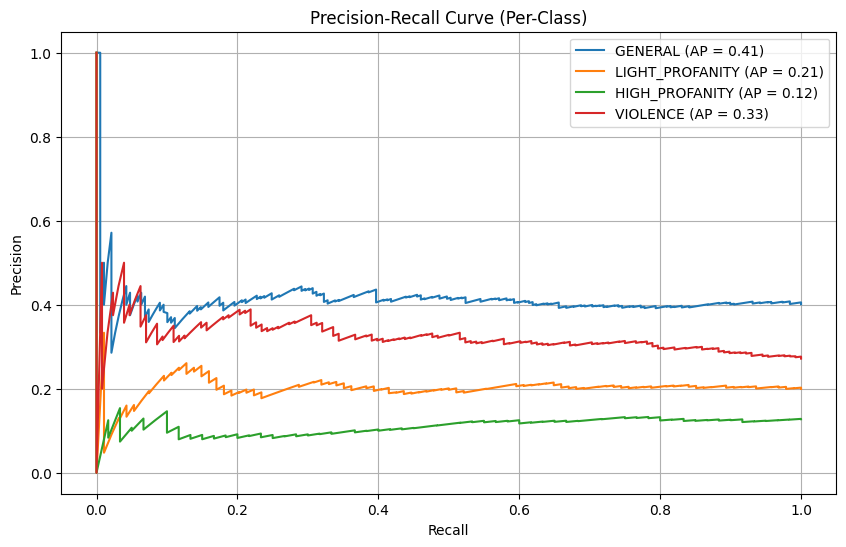

Confusion Matrix will be saved as ResBiLSTM_prev_cm.png


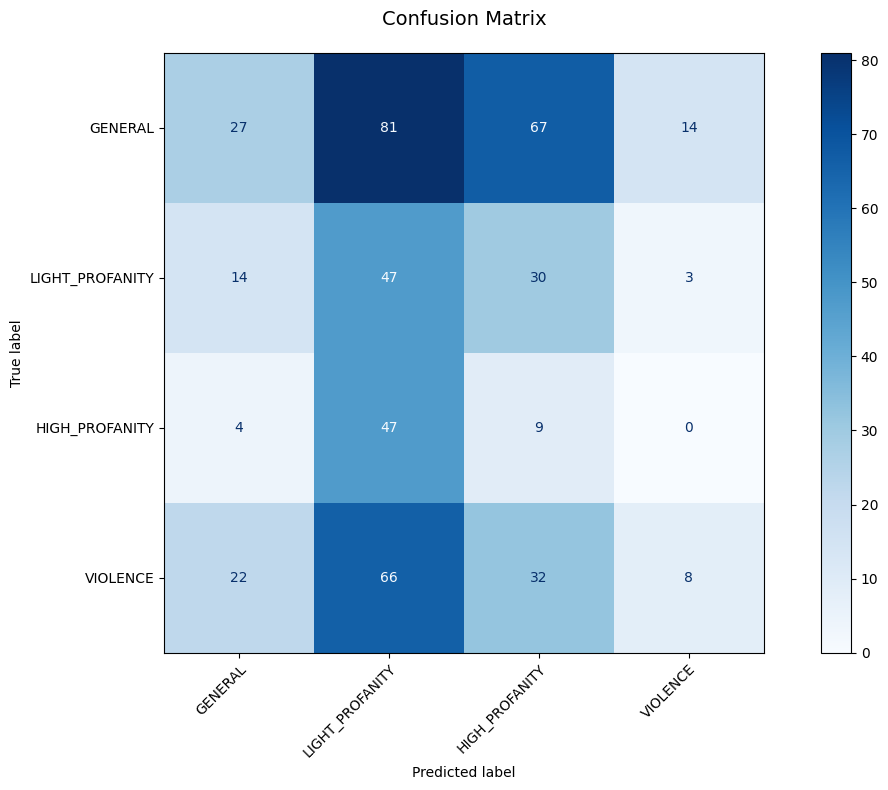

In [29]:
ResBiLSTM_prev_report = evaluate_model(ResBiLSTM_prev, test_loader, label_map, save_name="ResBiLSTM_prev")

## previous residual lstm implementation with high lr of 1e-4

In [32]:
ResBiLSTM_prev2_params = {
   "input_dim" : embeddings_size,
    "hidden_dim" : 148,
    "num_classes" : num_classes,
    "num_layers" : 1,
    "bidirectional" : True,
    "lr" : 1e-2,
    "weight_decay" : 1e-4,
    "train_batch_size" : 16,
    "test_batch_size" : 16,
    "val_batch_size" : 16,
    "dropout" : 0.4,
    "warmup_ratio" : 0.1,
    "epochs" : 20,
    "label_smoothing" : 0,
    "early_stopping_patience" : 3,
    "lstm_dropout" : 0
}

ResBiLSTM_prev2 = ResBiLSTMAttn_prev(
    input_dim=ResBiLSTM_prev2_params["input_dim"],
    hidden_dim=ResBiLSTM_prev2_params["hidden_dim"],
    num_classes=ResBiLSTM_prev2_params["num_classes"],
    num_layers= ResBiLSTM_prev2_params["num_layers"],
    dropout=ResBiLSTM_prev2_params["dropout"],
    bidirectional=ResBiLSTM_prev2_params["bidirectional"],
).to(device)

# Loss function
ResBiLSTM_prev2_criterion = nn.CrossEntropyLoss(label_smoothing=ResBiLSTM_prev2_params["label_smoothing"])

# Optimizer using unpacking
ResBiLSTM_prev2_optimizer = torch.optim.AdamW(
    ResBiLSTM_prev2.parameters(),
    lr=ResBiLSTM_prev2_params["lr"],
    weight_decay=ResBiLSTM_prev2_params["weight_decay"]
)


ResBiLSTM_prev2_scheduler = CosineAnnealingLR(ResBiLSTM_prev2_optimizer, T_max=len(train_loader) * ResBiLSTM_prev2_params["epochs"])

print(ResBiLSTM_prev2)
print("\n----------------------------------------------------\n")
print(count_parameters(ResBiLSTM_prev2))


ResBiLSTMAttn_prev(
  (lstm): ResLSTM(
    (dropout_layer): Dropout(p=0, inplace=False)
    (forward_cells): ModuleList(
      (0): ResLSTMLayer(
        (cell): ResLSTMCell()
      )
    )
    (backward_cells): ModuleList(
      (0): ResLSTMLayer(
        (cell): ResLSTMCell()
      )
    )
  )
  (ln): LayerNorm((296,), eps=1e-05, elementwise_affine=True)
  (dropout): Dropout(p=0.4, inplace=False)
  (attn): Linear(in_features=296, out_features=1, bias=True)
  (fc): Linear(in_features=296, out_features=4, bias=True)
)

----------------------------------------------------

666893


Epoch 1/20 | Train Loss: 1.9465 | Val Loss: 12.7732 | Train Acc: 23.48% | Val Acc: 26.75%
Epoch 2/20 | Train Loss: 6.1355 | Val Loss: 7.2248 | Train Acc: 30.36% | Val Acc: 20.81%
Epoch 3/20 | Train Loss: 3.1574 | Val Loss: 6.4029 | Train Acc: 38.38% | Val Acc: 31.21%
Epoch 4/20 | Train Loss: 13.7985 | Val Loss: 6.2451 | Train Acc: 25.42% | Val Acc: 28.66%
Epoch 5/20 | Train Loss: 3.1696 | Val Loss: 1.1538 | Train Acc: 42.39% | Val Acc: 56.69%
Epoch 6/20 | Train Loss: 1.2514 | Val Loss: 1.1698 | Train Acc: 52.54% | Val Acc: 56.05%
Epoch 7/20 | Train Loss: 1.0921 | Val Loss: 1.0368 | Train Acc: 58.17% | Val Acc: 62.63%
Epoch 8/20 | Train Loss: 0.9781 | Val Loss: 0.8489 | Train Acc: 63.61% | Val Acc: 68.37%
Epoch 9/20 | Train Loss: 0.8734 | Val Loss: 0.8726 | Train Acc: 68.26% | Val Acc: 68.79%
Epoch 10/20 | Train Loss: 0.8303 | Val Loss: 0.7940 | Train Acc: 70.33% | Val Acc: 71.76%
Epoch 11/20 | Train Loss: 0.7774 | Val Loss: 0.8114 | Train Acc: 72.08% | Val Acc: 71.13%
Epoch 12/20 | Tra

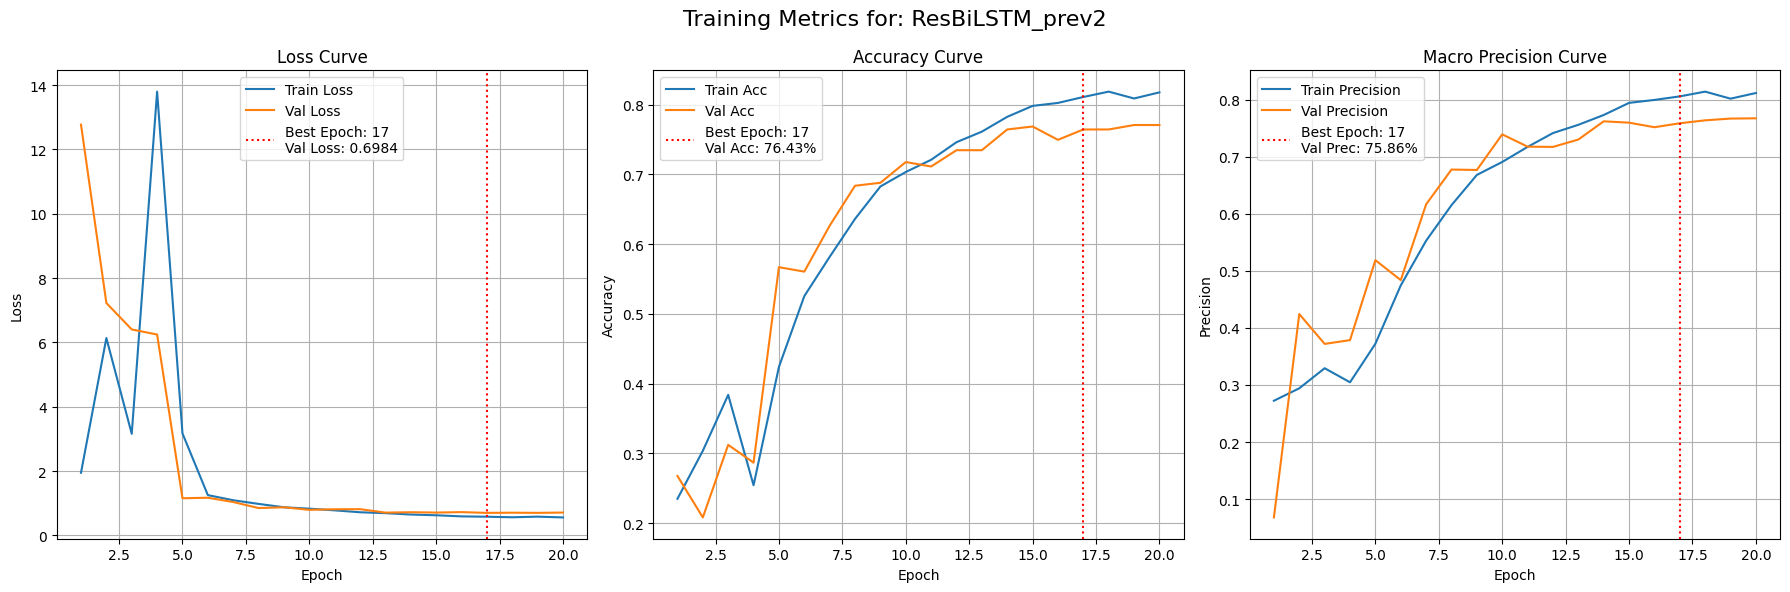

Matthews correlation coefficient: 0.6669758119555513
-------------------------------------

Classification Report:
                 precision    recall  f1-score   support

        GENERAL       0.81      0.81      0.81       190
LIGHT_PROFANITY       0.74      0.68      0.71        94
 HIGH_PROFANITY       0.77      0.73      0.75        60
       VIOLENCE       0.72      0.78      0.75       127

       accuracy                           0.76       471
      macro avg       0.76      0.75      0.75       471
   weighted avg       0.77      0.76      0.76       471



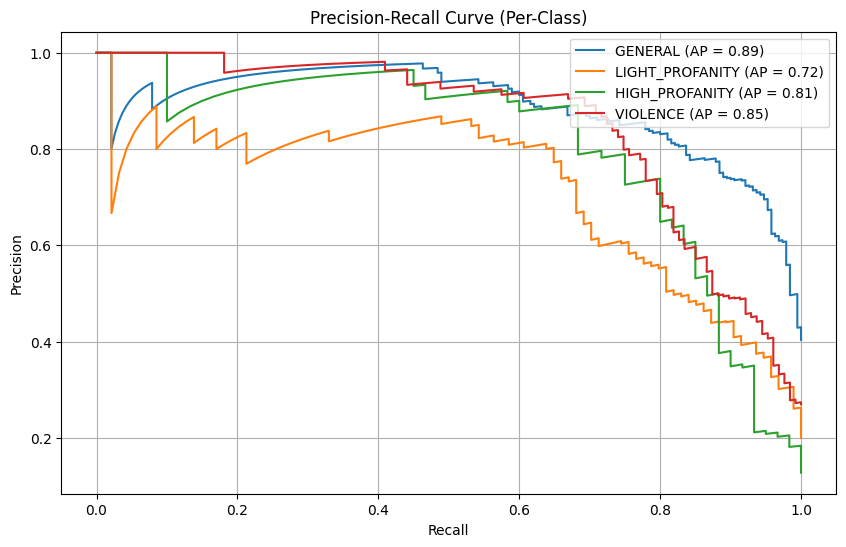

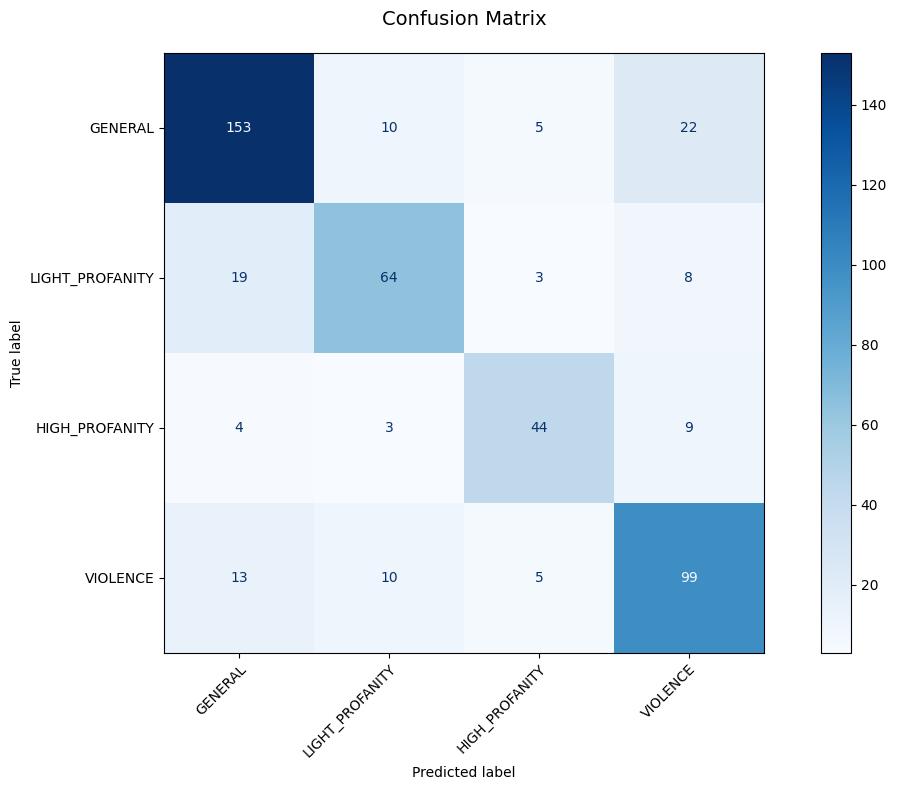

Matthews correlation coefficient: 0.6705005206732628
-------------------------------------

Classification Report:
                 precision    recall  f1-score   support

        GENERAL       0.87      0.78      0.82       189
LIGHT_PROFANITY       0.74      0.65      0.69        94
 HIGH_PROFANITY       0.64      0.78      0.71        60
       VIOLENCE       0.71      0.81      0.76       128

       accuracy                           0.76       471
      macro avg       0.74      0.76      0.74       471
   weighted avg       0.77      0.76      0.76       471

PR curve will be saved as ResBiLSTM_prev2_PR.png


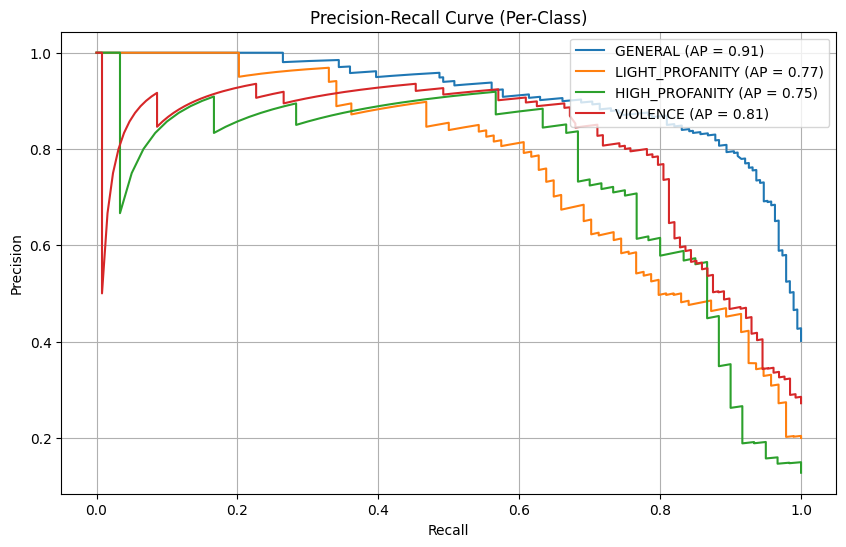

Confusion Matrix will be saved as ResBiLSTM_prev2_cm.png


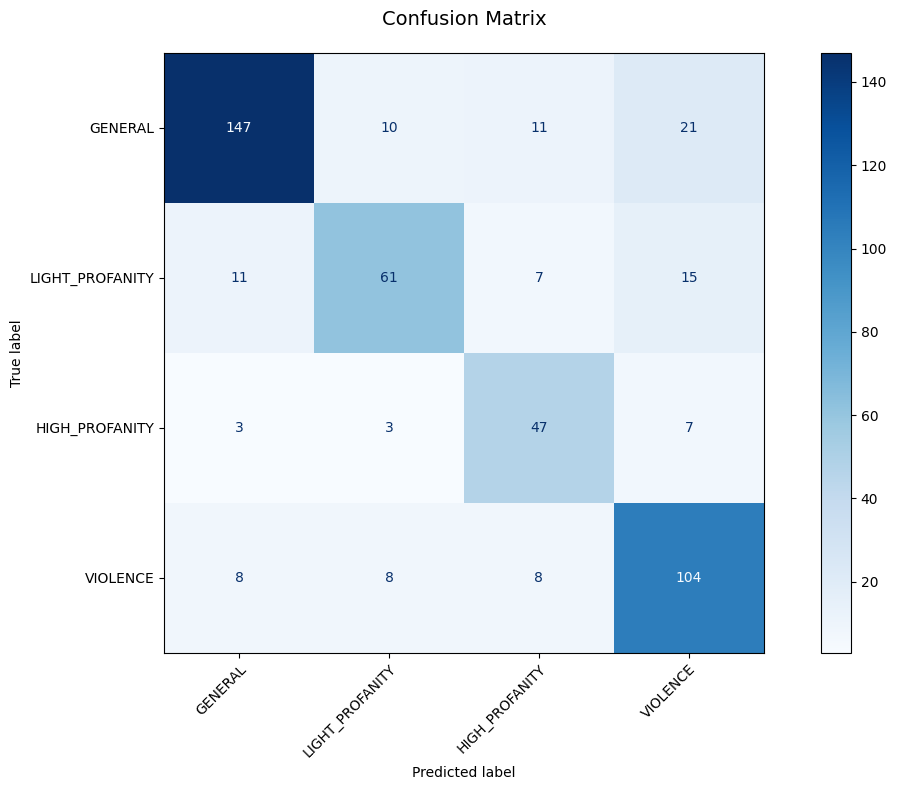

In [33]:
ResBiLSTM_prev2, ResBiLSTM_prev2_train_losses, ResBiLSTM_prev2_val_losses = model_train(ResBiLSTM_prev2, ResBiLSTM_prev2_criterion, ResBiLSTM_prev2_optimizer, train_loader, val_loader, scheduler=ResBiLSTM_prev2_scheduler, save_name="ResBiLSTM_prev2", epochs=ResBiLSTM_prev2_params["epochs"])
evaluate_model(ResBiLSTM_prev2, val_loader, label_map)
ResBiLSTM_prev2_report = evaluate_model(ResBiLSTM_prev2, test_loader, label_map, save_name="ResBiLSTM_prev2")

## MLFLOW Logging

In [35]:
!pip install -q mlflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.7/24.7 MB 54.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 74.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 733.8/733.8 kB 44.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.3/95.3 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.4/203.4 kB 17.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.4/62.4 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 6.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.


In [36]:
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
secret_value_0 = user_secrets.get_secret("dagshub")

In [37]:
import mlflow, os
import pickle

os.environ["MLFLOW_TRACKING_USERNAME"] = "tamangangel2057"
os.environ["MLFLOW_TRACKING_PASSWORD"] = secret_value_0  

# Initialize MLflow tracking
mlflow.set_tracking_uri("https://dagshub.com/tamangangel2057/Nephased.mlflow")

# Initialize Mlflow experiment
experiment = mlflow.get_experiment_by_name("Word_embedding_reslstm")
experiment_id = experiment.experiment_id
print(experiment_id)

1


In [56]:
# Start the run

torch.save(dnn.state_dict(), "dnn_state_dict.pt")

with mlflow.start_run(experiment_id=experiment_id, run_name="Fasttext_DNN"):
    mlflow.log_params(dnn_params)
    
    # For saving losses list
    losses = {
        "train_losses": dnn_train_losses,
        "val_losses": dnn_val_losses
    }
    save_path = "/kaggle/working/dnn_losses.pkl"
    try:
        with open(save_path, "wb") as f:
            pickle.dump(losses, f)
        print(f"Losses saved: {save_path}")
    except Exception as e:
        print(f"Failed to save losses: {str(e)}")

    mlflow.log_metrics({
        # Global accuracy
        "accuracy": dnn_report["accuracy"],

        # Per-class metrics (0 to 3)
        "precision_0": dnn_report["0"]["precision"],
        "recall_0": dnn_report["0"]["recall"],
        "f1_0": dnn_report["0"]["f1-score"],
        "support_0": dnn_report["0"]["support"],

        "precision_1": dnn_report["1"]["precision"],
        "recall_1": dnn_report["1"]["recall"],
        "f1_1": dnn_report["1"]["f1-score"],
        "support_1": dnn_report["1"]["support"],

        "precision_2": dnn_report["2"]["precision"],
        "recall_2": dnn_report["2"]["recall"],
        "f1_2": dnn_report["2"]["f1-score"],
        "support_2": dnn_report["2"]["support"],

        "precision_3": dnn_report["3"]["precision"],
        "recall_3": dnn_report["3"]["recall"],
        "f1_3": dnn_report["3"]["f1-score"],
        "support_3": dnn_report["3"]["support"],

        # Macro average
        "macro_precision": dnn_report["macro avg"]["precision"],
        "macro_recall": dnn_report["macro avg"]["recall"],
        "macro_f1": dnn_report["macro avg"]["f1-score"],
        "macro_support": dnn_report["macro avg"]["support"],

        # Weighted average
        "weighted_precision": dnn_report["weighted avg"]["precision"],
        "weighted_recall": dnn_report["weighted avg"]["recall"],
        "weighted_f1": dnn_report["weighted avg"]["f1-score"],
        "weighted_support": dnn_report["weighted avg"]["support"],

        # MCC
        "mcc":dnn_report["mcc"],
    })

    # Log all plots
    mlflow.log_artifact("/kaggle/working/DNN_loss.png", artifact_path="plots")
    mlflow.log_artifact("/kaggle/working/DNN_PR.png", artifact_path="plots")
    mlflow.log_artifact("/kaggle/working/DNN_cm.png", artifact_path="plots")

    # Log weights
    mlflow.log_artifact("dnn_state_dict.pt", artifact_path="model")

    # Log losses
    mlflow.log_artifact("dnn_losses.pkl", artifact_path="Losses")

Losses saved: /kaggle/working/dnn_losses.pkl
🏃 View run Fasttext_DNN at: https://dagshub.com/tamangangel2057/Nephased.mlflow/#/experiments/1/runs/6650af43ca1a46e3ba157ed74e5a635b
🧪 View experiment at: https://dagshub.com/tamangangel2057/Nephased.mlflow/#/experiments/1


In [57]:
# Start the run

torch.save(BiLSTM.state_dict(), "BiLSTM_state_dict.pt")

with mlflow.start_run(experiment_id=experiment_id, run_name="Fasttext_BiLSTM"):
    mlflow.log_params(BiLSTM_params)
    
    # For saving losses list
    losses = {
        "train_losses": BiLSTM_train_losses,
        "val_losses": BiLSTM_val_losses
    }
    save_path = "/kaggle/working/BiLSTM_losses.pkl"
    try:
        with open(save_path, "wb") as f:
            pickle.dump(losses, f)
        print(f"Losses saved: {save_path}")
    except Exception as e:
        print(f"Failed to save losses: {str(e)}")

    mlflow.log_metrics({
        # Global accuracy
        "accuracy": BiLSTM_report["accuracy"],

        # Per-class metrics (0 to 3)
        "precision_0": BiLSTM_report["0"]["precision"],
        "recall_0": BiLSTM_report["0"]["recall"],
        "f1_0": BiLSTM_report["0"]["f1-score"],
        "support_0": BiLSTM_report["0"]["support"],

        "precision_1": BiLSTM_report["1"]["precision"],
        "recall_1": BiLSTM_report["1"]["recall"],
        "f1_1": BiLSTM_report["1"]["f1-score"],
        "support_1": BiLSTM_report["1"]["support"],

        "precision_2": BiLSTM_report["2"]["precision"],
        "recall_2": BiLSTM_report["2"]["recall"],
        "f1_2": BiLSTM_report["2"]["f1-score"],
        "support_2": BiLSTM_report["2"]["support"],

        "precision_3": BiLSTM_report["3"]["precision"],
        "recall_3": BiLSTM_report["3"]["recall"],
        "f1_3": BiLSTM_report["3"]["f1-score"],
        "support_3": BiLSTM_report["3"]["support"],

        # Macro average
        "macro_precision": BiLSTM_report["macro avg"]["precision"],
        "macro_recall": BiLSTM_report["macro avg"]["recall"],
        "macro_f1": BiLSTM_report["macro avg"]["f1-score"],
        "macro_support": BiLSTM_report["macro avg"]["support"],

        # Weighted average
        "weighted_precision": BiLSTM_report["weighted avg"]["precision"],
        "weighted_recall": BiLSTM_report["weighted avg"]["recall"],
        "weighted_f1": BiLSTM_report["weighted avg"]["f1-score"],
        "weighted_support": BiLSTM_report["weighted avg"]["support"],

        # MCC
        "mcc":BiLSTM_report["mcc"],
    })

    # Log all plots
    mlflow.log_artifact("/kaggle/working/BiLSTM_loss.png", artifact_path="plots")
    mlflow.log_artifact("/kaggle/working/BiLSTM_PR.png", artifact_path="plots")
    mlflow.log_artifact("/kaggle/working/BiLSTM_cm.png", artifact_path="plots")

    # Log weights
    mlflow.log_artifact("BiLSTM_state_dict.pt", artifact_path="model")

    # Log losses
    mlflow.log_artifact("BiLSTM_losses.pkl", artifact_path="Losses")

Losses saved: /kaggle/working/BiLSTM_losses.pkl
🏃 View run Fasttext_BiLSTM at: https://dagshub.com/tamangangel2057/Nephased.mlflow/#/experiments/1/runs/3649e7a8fa754fa6a3368138736e5b51
🧪 View experiment at: https://dagshub.com/tamangangel2057/Nephased.mlflow/#/experiments/1


In [58]:
# Start the run

torch.save(ResBiLSTM.state_dict(), "ResBiLSTM_state_dict.pt")

with mlflow.start_run(experiment_id=experiment_id, run_name="Fasttext_ResBiLSTM"):
    mlflow.log_params(ResBiLSTM_params)
    
    # For saving losses list
    losses = {
        "train_losses": ResBiLSTM_train_losses,
        "val_losses": ResBiLSTM_val_losses
    }
    save_path = "/kaggle/working/ResBiLSTM_losses.pkl"
    try:
        with open(save_path, "wb") as f:
            pickle.dump(losses, f)
        print(f"Losses saved: {save_path}")
    except Exception as e:
        print(f"Failed to save losses: {str(e)}")

    mlflow.log_metrics({
        # Global accuracy
        "accuracy": ResBiLSTM_report["accuracy"],

        # Per-class metrics (0 to 3)
        "precision_0": ResBiLSTM_report["0"]["precision"],
        "recall_0": ResBiLSTM_report["0"]["recall"],
        "f1_0": ResBiLSTM_report["0"]["f1-score"],
        "support_0": ResBiLSTM_report["0"]["support"],

        "precision_1": ResBiLSTM_report["1"]["precision"],
        "recall_1": ResBiLSTM_report["1"]["recall"],
        "f1_1": ResBiLSTM_report["1"]["f1-score"],
        "support_1": ResBiLSTM_report["1"]["support"],

        "precision_2": ResBiLSTM_report["2"]["precision"],
        "recall_2": ResBiLSTM_report["2"]["recall"],
        "f1_2": ResBiLSTM_report["2"]["f1-score"],
        "support_2": ResBiLSTM_report["2"]["support"],

        "precision_3": ResBiLSTM_report["3"]["precision"],
        "recall_3": ResBiLSTM_report["3"]["recall"],
        "f1_3": ResBiLSTM_report["3"]["f1-score"],
        "support_3": ResBiLSTM_report["3"]["support"],

        # Macro average
        "macro_precision": ResBiLSTM_report["macro avg"]["precision"],
        "macro_recall": ResBiLSTM_report["macro avg"]["recall"],
        "macro_f1": ResBiLSTM_report["macro avg"]["f1-score"],
        "macro_support": ResBiLSTM_report["macro avg"]["support"],

        # Weighted average
        "weighted_precision": ResBiLSTM_report["weighted avg"]["precision"],
        "weighted_recall": ResBiLSTM_report["weighted avg"]["recall"],
        "weighted_f1": ResBiLSTM_report["weighted avg"]["f1-score"],
        "weighted_support": ResBiLSTM_report["weighted avg"]["support"],

        # MCC
        "mcc":ResBiLSTM_report["mcc"],
    })

    # Log all plots
    mlflow.log_artifact("/kaggle/working/ResBiLSTM_loss.png", artifact_path="plots")
    mlflow.log_artifact("/kaggle/working/ResBiLSTM_PR.png", artifact_path="plots")
    mlflow.log_artifact("/kaggle/working/ResBiLSTM_cm.png", artifact_path="plots")

    # Log weights
    mlflow.log_artifact("ResBiLSTM_state_dict.pt", artifact_path="model")

    # Log losses
    mlflow.log_artifact("ResBiLSTM_losses.pkl", artifact_path="Losses")

Losses saved: /kaggle/working/ResBiLSTM_losses.pkl
🏃 View run Fasttext_ResBiLSTM at: https://dagshub.com/tamangangel2057/Nephased.mlflow/#/experiments/1/runs/501a63257f144585ac17177b92cad42f
🧪 View experiment at: https://dagshub.com/tamangangel2057/Nephased.mlflow/#/experiments/1


In [59]:
# Start the run

torch.save(BiLSTM2.state_dict(), "BiLSTM2_state_dict.pt")

with mlflow.start_run(experiment_id=experiment_id, run_name="Fasttext_BiLSTM2"):
    mlflow.log_params(BiLSTM2_params)
    
    # For saving losses list
    losses = {
        "train_losses": BiLSTM2_train_losses,
        "val_losses": BiLSTM2_val_losses
    }
    save_path = "/kaggle/working/BiLSTM2_losses.pkl"
    try:
        with open(save_path, "wb") as f:
            pickle.dump(losses, f)
        print(f"Losses saved: {save_path}")
    except Exception as e:
        print(f"Failed to save losses: {str(e)}")

    mlflow.log_metrics({
        # Global accuracy
        "accuracy": BiLSTM2_report["accuracy"],

        # Per-class metrics (0 to 3)
        "precision_0": BiLSTM2_report["0"]["precision"],
        "recall_0": BiLSTM2_report["0"]["recall"],
        "f1_0": BiLSTM2_report["0"]["f1-score"],
        "support_0": BiLSTM2_report["0"]["support"],

        "precision_1": BiLSTM2_report["1"]["precision"],
        "recall_1": BiLSTM2_report["1"]["recall"],
        "f1_1": BiLSTM2_report["1"]["f1-score"],
        "support_1": BiLSTM2_report["1"]["support"],

        "precision_2": BiLSTM2_report["2"]["precision"],
        "recall_2": BiLSTM2_report["2"]["recall"],
        "f1_2": BiLSTM2_report["2"]["f1-score"],
        "support_2": BiLSTM2_report["2"]["support"],

        "precision_3": BiLSTM2_report["3"]["precision"],
        "recall_3": BiLSTM2_report["3"]["recall"],
        "f1_3": BiLSTM2_report["3"]["f1-score"],
        "support_3": BiLSTM2_report["3"]["support"],

        # Macro average
        "macro_precision": BiLSTM2_report["macro avg"]["precision"],
        "macro_recall": BiLSTM2_report["macro avg"]["recall"],
        "macro_f1": BiLSTM2_report["macro avg"]["f1-score"],
        "macro_support": BiLSTM2_report["macro avg"]["support"],

        # Weighted average
        "weighted_precision": BiLSTM2_report["weighted avg"]["precision"],
        "weighted_recall": BiLSTM2_report["weighted avg"]["recall"],
        "weighted_f1": BiLSTM2_report["weighted avg"]["f1-score"],
        "weighted_support": BiLSTM2_report["weighted avg"]["support"],

        # MCC
        "mcc":BiLSTM2_report["mcc"],
    })

    # Log all plots
    mlflow.log_artifact("/kaggle/working/BiLSTM2_loss.png", artifact_path="plots")
    mlflow.log_artifact("/kaggle/working/BiLSTM2_PR.png", artifact_path="plots")
    mlflow.log_artifact("/kaggle/working/BiLSTM2_cm.png", artifact_path="plots")

    # Log weights
    mlflow.log_artifact("BiLSTM2_state_dict.pt", artifact_path="model")

    # Log losses
    mlflow.log_artifact("BiLSTM2_losses.pkl", artifact_path="Losses")

Losses saved: /kaggle/working/BiLSTM2_losses.pkl
🏃 View run Fasttext_BiLSTM2 at: https://dagshub.com/tamangangel2057/Nephased.mlflow/#/experiments/1/runs/981ab4e724d74d01a26d469d943151da
🧪 View experiment at: https://dagshub.com/tamangangel2057/Nephased.mlflow/#/experiments/1


In [38]:
# Start the run

torch.save(ResBiLSTM_prev.state_dict(), "ResBiLSTM_prev_state_dict.pt")

with mlflow.start_run(experiment_id=experiment_id, run_name="Fasttext_ResBiLSTM_prev"):
    mlflow.log_params(ResBiLSTM_prev_params)
    
    # For saving losses list
    losses = {
        "train_losses": ResBiLSTM_prev_train_losses,
        "val_losses": ResBiLSTM_prev_val_losses
    }
    save_path = "/kaggle/working/ResBiLSTM_prev_losses.pkl"
    try:
        with open(save_path, "wb") as f:
            pickle.dump(losses, f)
        print(f"Losses saved: {save_path}")
    except Exception as e:
        print(f"Failed to save losses: {str(e)}")

    mlflow.log_metrics({
        # Global accuracy
        "accuracy": ResBiLSTM_prev_report["accuracy"],

        # Per-class metrics (0 to 3)
        "precision_0": ResBiLSTM_prev_report["0"]["precision"],
        "recall_0": ResBiLSTM_prev_report["0"]["recall"],
        "f1_0": ResBiLSTM_prev_report["0"]["f1-score"],
        "support_0": ResBiLSTM_prev_report["0"]["support"],

        "precision_1": ResBiLSTM_prev_report["1"]["precision"],
        "recall_1": ResBiLSTM_prev_report["1"]["recall"],
        "f1_1": ResBiLSTM_prev_report["1"]["f1-score"],
        "support_1": ResBiLSTM_prev_report["1"]["support"],

        "precision_2": ResBiLSTM_prev_report["2"]["precision"],
        "recall_2": ResBiLSTM_prev_report["2"]["recall"],
        "f1_2": ResBiLSTM_prev_report["2"]["f1-score"],
        "support_2": ResBiLSTM_prev_report["2"]["support"],

        "precision_3": ResBiLSTM_prev_report["3"]["precision"],
        "recall_3": ResBiLSTM_prev_report["3"]["recall"],
        "f1_3": ResBiLSTM_prev_report["3"]["f1-score"],
        "support_3": ResBiLSTM_prev_report["3"]["support"],

        # Macro average
        "macro_precision": ResBiLSTM_prev_report["macro avg"]["precision"],
        "macro_recall": ResBiLSTM_prev_report["macro avg"]["recall"],
        "macro_f1": ResBiLSTM_prev_report["macro avg"]["f1-score"],
        "macro_support": ResBiLSTM_prev_report["macro avg"]["support"],

        # Weighted average
        "weighted_precision": ResBiLSTM_prev_report["weighted avg"]["precision"],
        "weighted_recall": ResBiLSTM_prev_report["weighted avg"]["recall"],
        "weighted_f1": ResBiLSTM_prev_report["weighted avg"]["f1-score"],
        "weighted_support": ResBiLSTM_prev_report["weighted avg"]["support"],

        # MCC
        "mcc":ResBiLSTM_prev_report["mcc"],
    })

    # Log all plots
    mlflow.log_artifact("/kaggle/working/ResBiLSTM_prev_loss.png", artifact_path="plots")
    mlflow.log_artifact("/kaggle/working/ResBiLSTM_prev_PR.png", artifact_path="plots")
    mlflow.log_artifact("/kaggle/working/ResBiLSTM_prev_cm.png", artifact_path="plots")

    # Log weights
    mlflow.log_artifact("ResBiLSTM_prev_state_dict.pt", artifact_path="model")

    # Log losses
    mlflow.log_artifact("ResBiLSTM_prev_losses.pkl", artifact_path="Losses")

Losses saved: /kaggle/working/ResBiLSTM_prev_losses.pkl
🏃 View run Fasttext_ResBiLSTM_prev at: https://dagshub.com/tamangangel2057/Nephased.mlflow/#/experiments/1/runs/d2b64d61a76243b88c1cf62d5d5f523e
🧪 View experiment at: https://dagshub.com/tamangangel2057/Nephased.mlflow/#/experiments/1


In [39]:
# Start the run

torch.save(ResBiLSTM_prev2.state_dict(), "ResBiLSTM_prev2_state_dict.pt")

with mlflow.start_run(experiment_id=experiment_id, run_name="Fasttext_ResBiLSTM_prev2"):
    mlflow.log_params(ResBiLSTM_prev2_params)
    
    # For saving losses list
    losses = {
        "train_losses": ResBiLSTM_prev2_train_losses,
        "val_losses": ResBiLSTM_prev2_val_losses
    }
    save_path = "/kaggle/working/ResBiLSTM_prev2_losses.pkl"
    try:
        with open(save_path, "wb") as f:
            pickle.dump(losses, f)
        print(f"Losses saved: {save_path}")
    except Exception as e:
        print(f"Failed to save losses: {str(e)}")

    mlflow.log_metrics({
        # Global accuracy
        "accuracy": ResBiLSTM_prev2_report["accuracy"],

        # Per-class metrics (0 to 3)
        "precision_0": ResBiLSTM_prev2_report["0"]["precision"],
        "recall_0": ResBiLSTM_prev2_report["0"]["recall"],
        "f1_0": ResBiLSTM_prev2_report["0"]["f1-score"],
        "support_0": ResBiLSTM_prev2_report["0"]["support"],

        "precision_1": ResBiLSTM_prev2_report["1"]["precision"],
        "recall_1": ResBiLSTM_prev2_report["1"]["recall"],
        "f1_1": ResBiLSTM_prev2_report["1"]["f1-score"],
        "support_1": ResBiLSTM_prev2_report["1"]["support"],

        "precision_2": ResBiLSTM_prev2_report["2"]["precision"],
        "recall_2": ResBiLSTM_prev2_report["2"]["recall"],
        "f1_2": ResBiLSTM_prev2_report["2"]["f1-score"],
        "support_2": ResBiLSTM_prev2_report["2"]["support"],

        "precision_3": ResBiLSTM_prev2_report["3"]["precision"],
        "recall_3": ResBiLSTM_prev2_report["3"]["recall"],
        "f1_3": ResBiLSTM_prev2_report["3"]["f1-score"],
        "support_3": ResBiLSTM_prev2_report["3"]["support"],

        # Macro average
        "macro_precision": ResBiLSTM_prev2_report["macro avg"]["precision"],
        "macro_recall": ResBiLSTM_prev2_report["macro avg"]["recall"],
        "macro_f1": ResBiLSTM_prev2_report["macro avg"]["f1-score"],
        "macro_support": ResBiLSTM_prev2_report["macro avg"]["support"],

        # Weighted average
        "weighted_precision": ResBiLSTM_prev2_report["weighted avg"]["precision"],
        "weighted_recall": ResBiLSTM_prev2_report["weighted avg"]["recall"],
        "weighted_f1": ResBiLSTM_prev2_report["weighted avg"]["f1-score"],
        "weighted_support": ResBiLSTM_prev2_report["weighted avg"]["support"],

        # MCC
        "mcc":ResBiLSTM_prev2_report["mcc"],
    })

    # Log all plots
    mlflow.log_artifact("/kaggle/working/ResBiLSTM_prev2_loss.png", artifact_path="plots")
    mlflow.log_artifact("/kaggle/working/ResBiLSTM_prev2_PR.png", artifact_path="plots")
    mlflow.log_artifact("/kaggle/working/ResBiLSTM_prev2_cm.png", artifact_path="plots")

    # Log weights
    mlflow.log_artifact("ResBiLSTM_prev2_state_dict.pt", artifact_path="model")

    # Log losses
    mlflow.log_artifact("ResBiLSTM_prev2_losses.pkl", artifact_path="Losses")

Losses saved: /kaggle/working/ResBiLSTM_prev2_losses.pkl
🏃 View run Fasttext_ResBiLSTM_prev2 at: https://dagshub.com/tamangangel2057/Nephased.mlflow/#/experiments/1/runs/2b04e024bca34067953abe200c30f615
🧪 View experiment at: https://dagshub.com/tamangangel2057/Nephased.mlflow/#/experiments/1
